https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

### ***About Dataset***

**Context** <br>

Although there have been lot of studies undertaken in the past on factors affecting life expectancy considering demographic variables, income composition and mortality rates. It was found that affect of immunization and human development index was not taken into account in the past. Also, some of the past research was done considering multiple linear regression based on data set of one year for all the countries. Hence, this gives motivation to resolve both the factors stated previously by formulating a regression model based on mixed effects model and multiple linear regression while considering data from a period of 2000 to 2015 for all the countries. Important immunization like Hepatitis B, Polio and Diphtheria will also be considered. In a nutshell, this study will focus on immunization factors, mortality factors, economic factors, social factors and other health related factors as well. Since the observations this dataset are based on different countries, it will be easier for a country to determine the predicting factor which is contributing to lower value of life expectancy. This will help in suggesting a country which area should be given importance in order to efficiently improve the life expectancy of its population.

**Content** <br>

The project relies on accuracy of data. The Global Health Observatory (GHO) data repository under World Health Organization (WHO) keeps track of the health status as well as many other related factors for all countries The data-sets are made available to public for the purpose of health data analysis. The data-set related to life expectancy, health factors for 193 countries has been collected from the same WHO data repository website and its corresponding economic data was collected from United Nation website. Among all categories of health-related factors only those critical factors were chosen which are more representative. It has been observed that in the past 15 years , there has been a huge development in health sector resulting in improvement of human mortality rates especially in the developing nations in comparison to the past 30 years. Therefore, in this project we have considered data from year 2000-2015 for 193 countries for further analysis. The individual data files have been merged together into a single data-set. On initial visual inspection of the data showed some missing values. As the data-sets were from WHO, we found no evident errors. Missing data was handled in R software by using Missmap command. The result indicated that most of the missing data was for population, Hepatitis B and GDP. The missing data were from less known countries like Vanuatu, Tonga, Togo, Cabo Verde etc. Finding all data for these countries was difficult and hence, it was decided that we exclude these countries from the final model data-set. The final merged file(final dataset) consists of 22 Columns and 2938 rows which meant 20 predicting variables. All predicting variables was then divided into several broad categories: ​Immunization related factors, Mortality factors, Economical factors and Social factors.

**Acknowledgements** <br>

The data was collected from WHO and United Nations website with the help of Deeksha Russell and Duan Wang.

**Inspiration** <br>

*The data-set aims to answer the following key questions:*
1. Does various predicting factors which has been chosen initially really affect the Life expectancy? What are the predicting variables actually affecting the life expectancy?
2. Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?
3. How does Infant and Adult mortality rates affect life expectancy?
4. Does Life Expectancy has positive or negative correlation with eating habits, lifestyle, exercise, smoking, drinking alcohol etc.
5. What is the impact of schooling on the lifespan of humans?
6. Does Life Expectancy have positive or negative relationship with drinking alcohol?
7. Do densely populated countries tend to have lower life expectancy?
8. What is the impact of Immunization coverage on life Expectancy?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
import pingouin as pg
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

### **Importing**, **cleaning** and **modeling**

In [2]:
# PIPELINE (parte1)
df = pd.read_csv('./data/Life Expectancy Data.csv')
df.columns = [col.strip().replace('  ', ' ') for col in df.columns]
df = df.dropna(subset='Life expectancy').sort_values(by=['Country','Year']).rename(columns={'thinness 1-19 years':'thinness 10-19 years'})
df = df.drop('percentage expenditure', axis=1) # coluna com valores errados

# dados de continente e subcontinente tirados da API: https://restcountries.com/v3.1/name/{country}
df_region = pd.read_csv('./data/region_subregion_all_countries.csv')
df = pd.merge(df, df_region, on='Country', how='left')

# de acordo com o próprio WHO, os dados de população estam errados ~https://data.who.int/countries/
# dados corretos foram tirados das APIs: https://restcountries.com/v3.1/name/{country}, "http://api.worldbank.org/v2/country/{country}/indicator/SP.POP.TOTL" 
df_population = pd.read_csv('./data/population_2000_2015_all_countries.csv')
df = pd.merge(df.drop('Population', axis=1), df_population, on=['Country','Year'], how='left')
df['Population'] = df['Population']*10**6

# para as colunas "a cada 1k pessoas", se valor > 1k ~> valor = nulo
for col in ['Adult Mortality', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles']:
    df.loc[df[col] > 1000, col] = None

# fillna com a mediana dado mesmo ano e região ~ a ideia é que o valor perdido (nulo) seja parecido com os valores do mesmo ano e da mesma região.
for col in ['Alcohol', 'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'GDP', 'thinness 10-19 years', 'thinness 5-9 years', 'Income composition of resources', 'Schooling', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles']:
    for i in df[df[col].isna()].index:
        region = df.loc[i, 'region']
        year = df.loc[i, 'Year']

        values_region_year = df[(df['region'] == region) & (df['Year']==year) & (df[col].notna())][col]
        if not values_region_year.shape[0]:
            values_region_year = df[(df['region'] == region) & (df['Year']>=year-1) & (df['Year']<=year+1) & (df[col].notna())][col]
            
        df.loc[i, col] = values_region_year.median()

df = df[[
    'Year', 'Country', 'region', 'subregion', 'Status', 'Population', 'Income composition of resources', 'Schooling', 'Alcohol', 'GDP', 'BMI', 'thinness 10-19 years', 'thinness 5-9 years',
    'Total expenditure', 'Hepatitis B', 'Polio', 'Diphtheria', 'Adult Mortality', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles', 'Life expectancy'
]].copy()

display(df)
display(df.sample().iloc[0])

,Year,Country,region,subregion,Status,Population,Income composition of resources,Schooling,Alcohol,GDP,...,Total expenditure,Hepatitis B,Polio,Diphtheria,Adult Mortality,infant deaths,under-five deaths,HIV/AIDS,Measles,Life expectancy
0,2000,Afghanistan,Asia,Southern Asia,Developing,20130000.0,0.338,5.5,0.01,114.560000,...,8.20,62.0,24.0,24.0,321.0,88.0,122.0,0.1,48.0,54.8
1,2001,Afghanistan,Asia,Southern Asia,Developing,20280000.0,0.340,5.9,0.01,117.496980,...,7.80,63.0,35.0,33.0,316.0,88.0,122.0,0.1,32.5,55.3
2,2002,Afghanistan,Asia,Southern Asia,Developing,21380000.0,0.341,6.2,0.01,187.845950,...,7.76,64.0,36.0,36.0,3.0,88.0,122.0,0.1,35.0,56.2
3,2003,Afghanistan,Asia,Southern Asia,Developing,22730000.0,0.373,6.5,0.01,198.728544,...,8.82,65.0,41.0,41.0,295.0,87.0,122.0,0.1,798.0,56.7
4,2004,Afghanistan,Asia,Southern Asia,Developing,23560000.0,0.381,6.8,0.02,219.141353,...,8.79,67.0,5.0,5.0,293.0,87.0,120.0,0.1,466.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,2011,Zimbabwe,Africa,Southern Africa,Developing,13600000.0,0.452,10.1,6.00,839.927936,...,6.31,94.0,93.0,93.0,464.0,28.0,42.0,13.3,0.0,54.9
2924,2012,Zimbabwe,Africa,Southern Africa,Developing,13820000.0,0.464,9.8,6.09,955.648466,...,6.69,97.0,95.0,95.0,429.0,26.0,39.0,8.8,0.0,56.6
2925,2013,Zimbabwe,Africa,Southern Africa,Developing,14010000.0,0.488,10.4,6.39,111.227396,...,6.88,95.0,95.0,95.0,399.0,25.0,36.0,6.8,0.0,58.0
2926,2014,Zimbabwe,Africa,Southern Africa,Developing,14210000.0,0.498,10.3,6.50,127.474620,...,6.44,91.0,92.0,91.0,371.0,23.0,34.0,6.3,0.0,59.2


Year                                          2009
Country                                   Zimbabwe
region                                      Africa
subregion                          Southern Africa
Status                                  Developing
Population                              13140000.0
Income composition of resources              0.419
Schooling                                      9.9
Alcohol                                       4.64
GDP                                      65.824121
BMI                                           29.0
thinness 10-19 years                           7.5
thinness 5-9 years                             7.4
Total expenditure                             6.26
Hepatitis B                                   73.0
Polio                                         69.0
Diphtheria                                    73.0
Adult Mortality                              587.0
infant deaths                                 30.0
under-five deaths              

### **EDA**

In [3]:

print(df.shape)
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

display(df.describe())

(2928, 23)


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
Year,int64,0,0.0,16,"[2000, 2001, 2002]"
Country,object,0,0.0,183,"[Afghanistan, Albania, Algeria]"
region,object,0,0.0,5,"[Asia, Europe, Africa]"
subregion,object,0,0.0,24,"[Southern Asia, Southeast Europe, Northern Afr..."
Status,object,0,0.0,2,"[Developing, Developed]"
Population,float64,0,0.0,1807,"[20130000.0, 20280000.0, 21380000.0]"
Income composition of resources,float64,0,0.0,664,"[0.338, 0.34, 0.341]"
Schooling,float64,0,0.0,196,"[5.5, 5.9, 6.2]"
Alcohol,float64,0,0.0,1077,"[0.01, 0.02, 0.03]"
GDP,float64,0,0.0,2538,"[114.56, 117.49698, 187.84595]"


,Year,Population,Income composition of resources,Schooling,Alcohol,GDP,BMI,thinness 10-19 years,thinness 5-9 years,Total expenditure,Hepatitis B,Polio,Diphtheria,Adult Mortality,infant deaths,under-five deaths,HIV/AIDS,Measles,Life expectancy
count,2928.00000,2.928000e+03,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,2007.50000,3.657920e+07,0.627663,12.002391,4.514810,6817.864517,38.042657,4.879337,4.908811,5.940331,82.394980,82.552937,82.326673,164.796448,24.025273,32.473019,1.747712,80.686475,69.224932
std,4.61056,1.371552e+08,0.208368,3.305709,4.009847,13310.302935,19.936234,4.405439,4.492878,2.409215,22.869488,23.360891,23.650226,124.292079,67.508220,87.347243,5.085542,171.399037,9.523867
min,2000.00000,5.000000e+04,0.000000,0.000000,0.010000,1.681350,1.000000,0.100000,0.100000,0.370000,1.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.100000,0.000000,36.300000
25%,2003.75000,2.110000e+06,0.491000,10.100000,0.867500,517.856585,19.200000,1.600000,1.600000,4.360000,81.000000,78.000000,78.000000,74.000000,0.000000,0.000000,0.100000,0.000000,63.100000
50%,2007.50000,8.160000e+06,0.677000,12.300000,3.675000,1820.702189,43.000000,3.400000,3.400000,5.760000,91.000000,93.000000,93.000000,144.000000,3.000000,4.000000,0.100000,10.000000,72.100000
75%,2011.25000,2.509250e+07,0.780000,14.300000,7.490000,5475.094150,56.100000,7.200000,7.300000,7.452500,96.000000,97.000000,97.000000,228.000000,22.000000,28.000000,0.800000,62.000000,75.700000
max,2015.00000,1.388000e+09,0.948000,20.700000,17.870000,119172.741800,77.600000,27.700000,28.600000,17.600000,99.000000,99.000000,99.000000,723.000000,1000.000000,943.000000,50.600000,999.000000,89.000000


#### *Univariate* Analysis

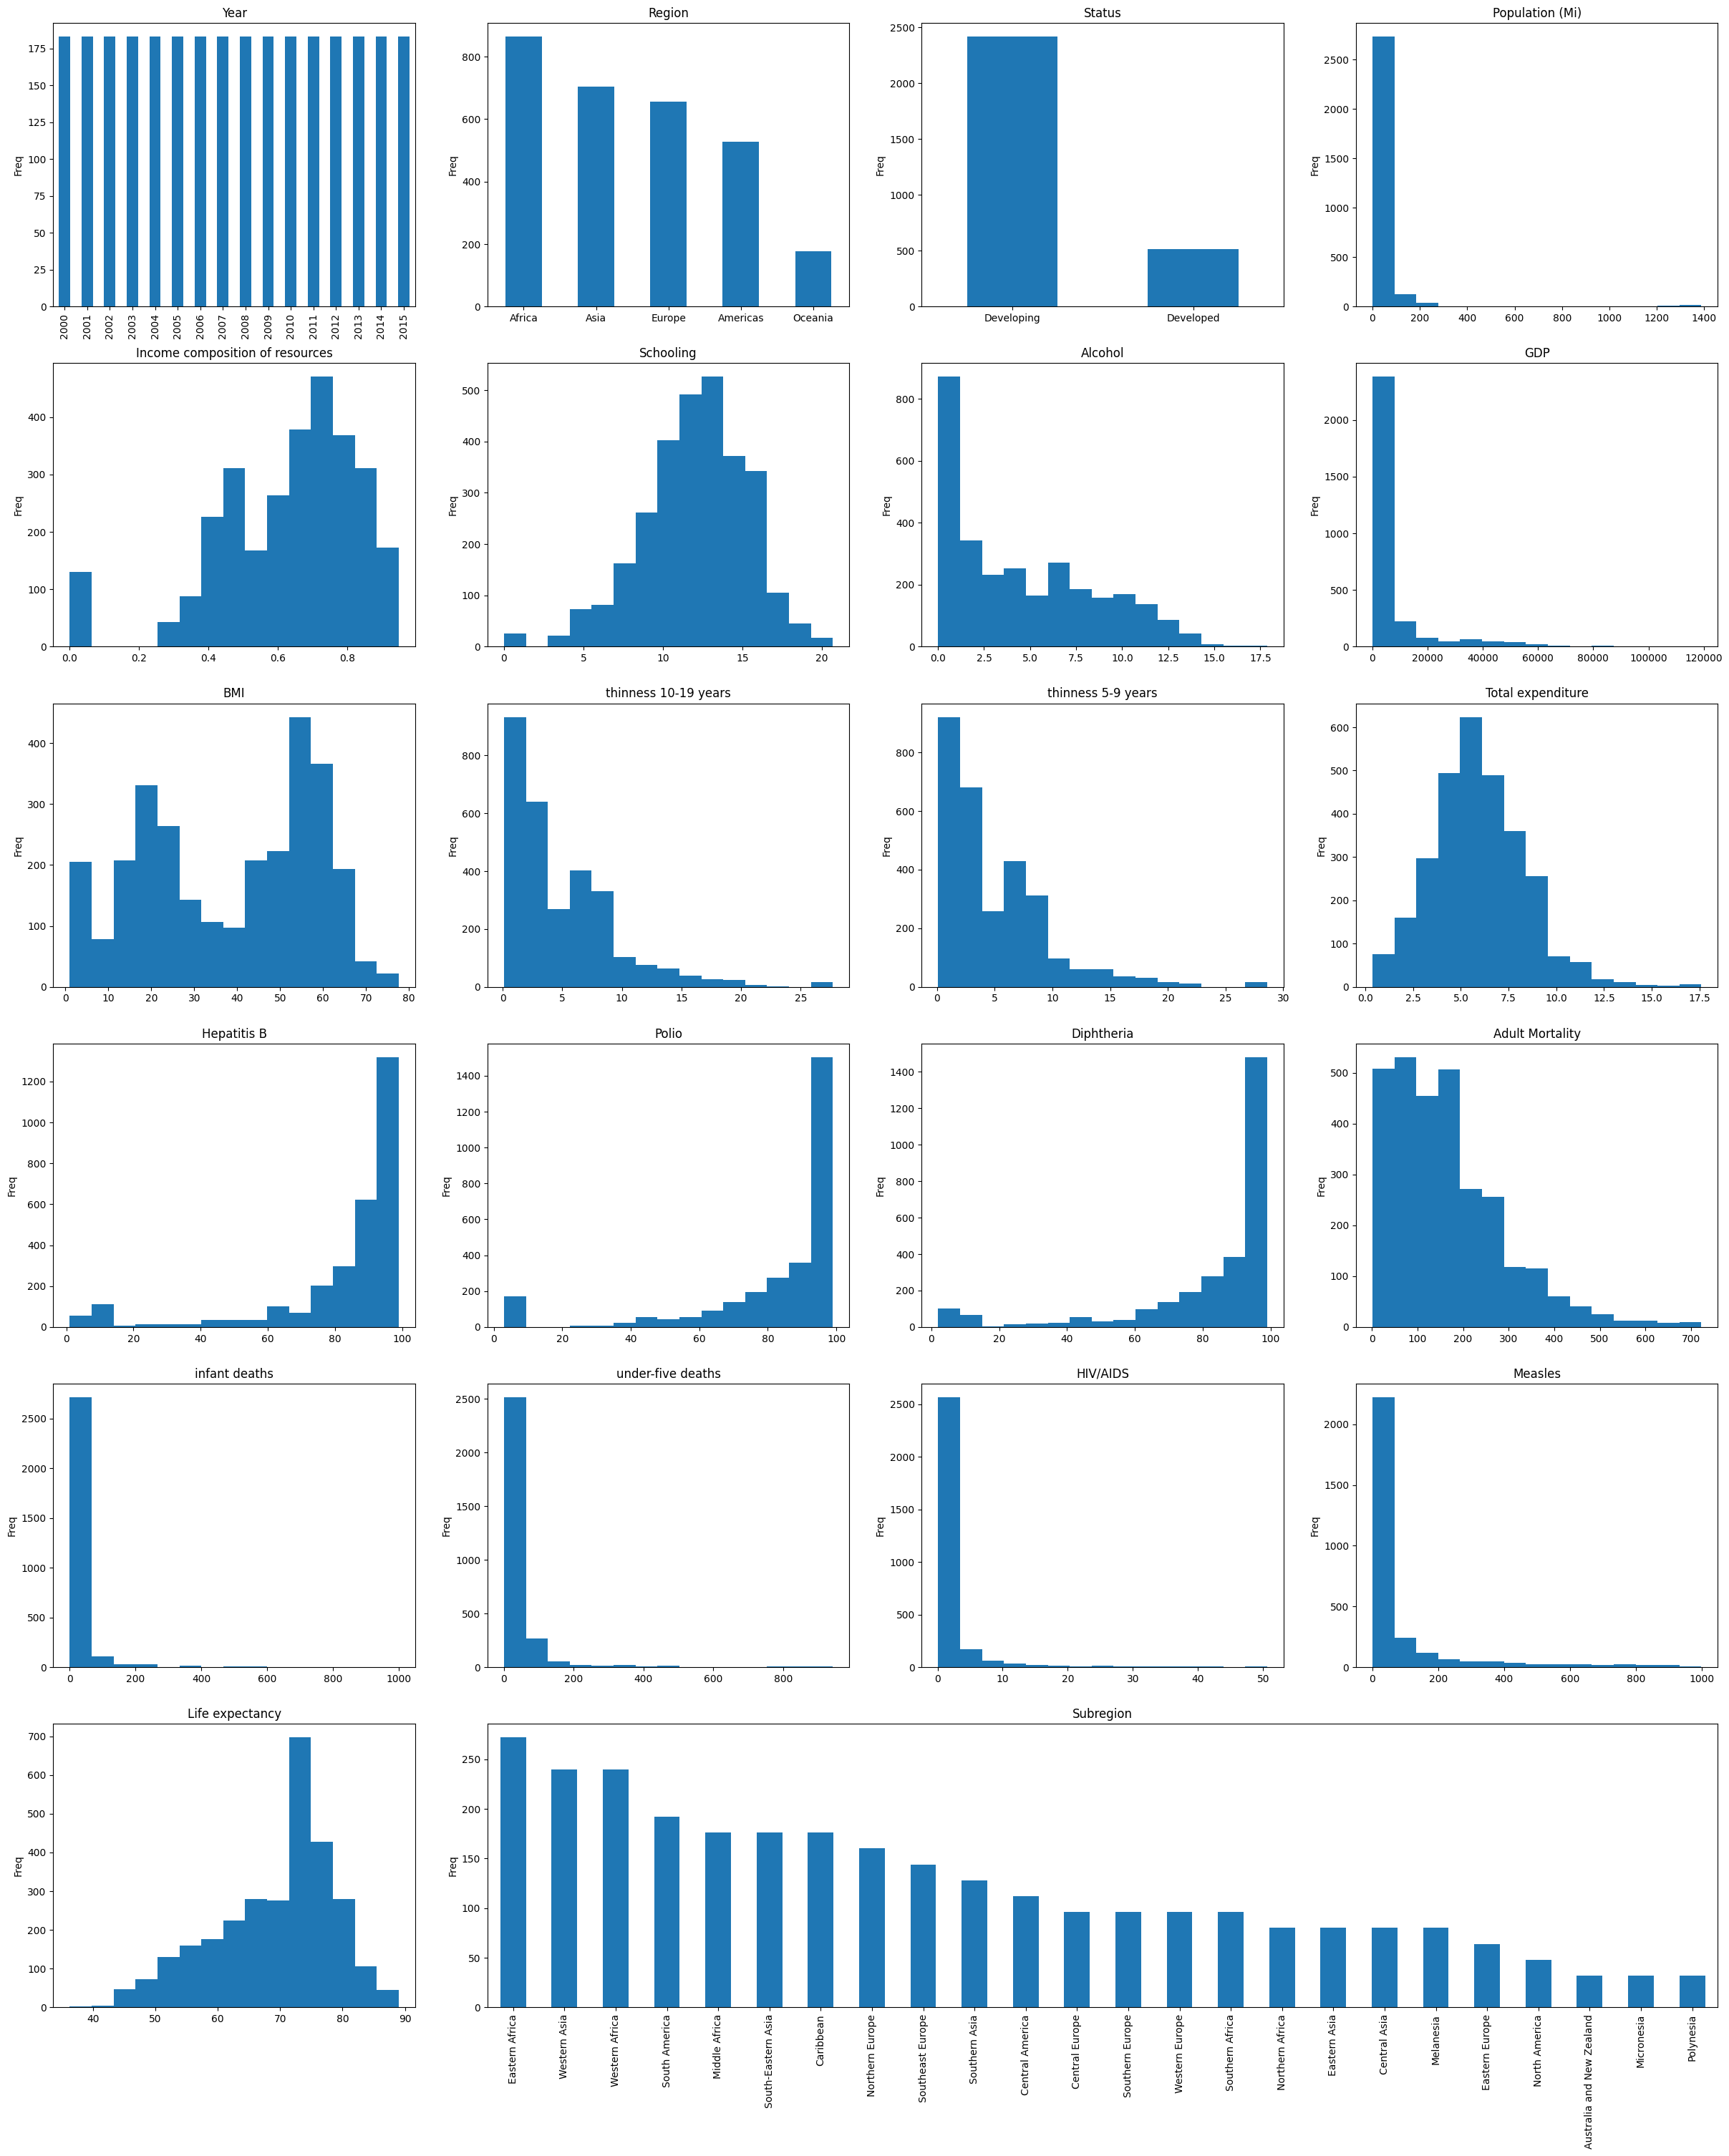

,Year,Population,Income composition of resources,Schooling,Alcohol,GDP,BMI,thinness 10-19 years,thinness 5-9 years,Total expenditure,Hepatitis B,Polio,Diphtheria,Adult Mortality,infant deaths,under-five deaths,HIV/AIDS,Measles,Life expectancy
count,2928.00000,2.928000e+03,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,2007.50000,3.657920e+07,0.627663,12.002391,4.514810,6817.864517,38.042657,4.879337,4.908811,5.940331,82.394980,82.552937,82.326673,164.796448,24.025273,32.473019,1.747712,80.686475,69.224932
std,4.61056,1.371552e+08,0.208368,3.305709,4.009847,13310.302935,19.936234,4.405439,4.492878,2.409215,22.869488,23.360891,23.650226,124.292079,67.508220,87.347243,5.085542,171.399037,9.523867
min,2000.00000,5.000000e+04,0.000000,0.000000,0.010000,1.681350,1.000000,0.100000,0.100000,0.370000,1.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.100000,0.000000,36.300000
25%,2003.75000,2.110000e+06,0.491000,10.100000,0.867500,517.856585,19.200000,1.600000,1.600000,4.360000,81.000000,78.000000,78.000000,74.000000,0.000000,0.000000,0.100000,0.000000,63.100000
50%,2007.50000,8.160000e+06,0.677000,12.300000,3.675000,1820.702189,43.000000,3.400000,3.400000,5.760000,91.000000,93.000000,93.000000,144.000000,3.000000,4.000000,0.100000,10.000000,72.100000
75%,2011.25000,2.509250e+07,0.780000,14.300000,7.490000,5475.094150,56.100000,7.200000,7.300000,7.452500,96.000000,97.000000,97.000000,228.000000,22.000000,28.000000,0.800000,62.000000,75.700000
max,2015.00000,1.388000e+09,0.948000,20.700000,17.870000,119172.741800,77.600000,27.700000,28.600000,17.600000,99.000000,99.000000,99.000000,723.000000,1000.000000,943.000000,50.600000,999.000000,89.000000


In [4]:

fig = plt.figure(figsize=(30, 6*6))
grid = gridspec.GridSpec(6, 4, figure=fig)

# 1° linha
ax1 = fig.add_subplot(grid[0, 0])
df['Year'].value_counts().plot.bar(ax=ax1)
ax1.set_title('Year')
ax1.set_xlabel(None)
ax1.set_ylabel('Freq')

ax2 = fig.add_subplot(grid[0, 1])
df['region'].value_counts().plot.bar(ax=ax2)
ax2.set_title('Region')
ax2.set_xlabel(None)
ax2.set_ylabel('Freq')
ax2.tick_params(axis='x', labelrotation=0)

ax3 = fig.add_subplot(grid[0, 2])
df['Status'].value_counts().plot.bar(ax=ax3)
ax3.set_title('Status')
ax3.set_xlabel(None)
ax3.set_ylabel('Freq')
ax3.tick_params(axis='x', labelrotation=0)

ax4 = fig.add_subplot(grid[0, 3])
(df['Population']/(10**6)).plot.hist(ax=ax4, bins=15)
ax4.set_title('Population (Mi)')
ax4.set_xlabel(None)
ax4.set_ylabel('Freq')

# 2° linha
ax5 = fig.add_subplot(grid[1, 0])
df['Income composition of resources'].plot.hist(ax=ax5, bins=15)
ax5.set_title('Income composition of resources')
ax5.set_xlabel(None)
ax5.set_ylabel('Freq')

ax6 = fig.add_subplot(grid[1, 1])
df['Schooling'].plot.hist(ax=ax6, bins=15)
ax6.set_title('Schooling')
ax6.set_xlabel(None)
ax6.set_ylabel('Freq')

ax7 = fig.add_subplot(grid[1, 2])
df['Alcohol'].plot.hist(ax=ax7, bins=15)
ax7.set_title('Alcohol')
ax7.set_xlabel(None)
ax7.set_ylabel('Freq')

ax8 = fig.add_subplot(grid[1, 3])
df['GDP'].plot.hist(ax=ax8, bins=15)
ax8.set_title('GDP')
ax8.set_xlabel(None)
ax8.set_ylabel('Freq')

# 3° linha
ax9 = fig.add_subplot(grid[2, 0])
df['BMI'].plot.hist(ax=ax9, bins=15)
ax9.set_title('BMI')
ax9.set_xlabel(None)
ax9.set_ylabel('Freq')

ax10 = fig.add_subplot(grid[2, 1])
df['thinness 10-19 years'].plot.hist(ax=ax10, bins=15)
ax10.set_title('thinness 10-19 years')
ax10.set_xlabel(None)
ax10.set_ylabel('Freq')

ax11 = fig.add_subplot(grid[2, 2])
df['thinness 5-9 years'].plot.hist(ax=ax11, bins=15)
ax11.set_title('thinness 5-9 years')
ax11.set_xlabel(None)
ax11.set_ylabel('Freq')

ax12 = fig.add_subplot(grid[2, 3])
df['Total expenditure'].plot.hist(ax=ax12, bins=15)
ax12.set_title('Total expenditure')
ax12.set_xlabel(None)
ax12.set_ylabel('Freq')

# 4° linha
ax13 = fig.add_subplot(grid[3, 0])
df['Hepatitis B'].plot.hist(ax=ax13, bins=15)
ax13.set_title('Hepatitis B')
ax13.set_xlabel(None)
ax13.set_ylabel('Freq')

ax14 = fig.add_subplot(grid[3, 1])
df['Polio'].plot.hist(ax=ax14, bins=15)
ax14.set_title('Polio')
ax14.set_xlabel(None)
ax14.set_ylabel('Freq')

ax15 = fig.add_subplot(grid[3, 2])
df['Diphtheria'].plot.hist(ax=ax15, bins=15)
ax15.set_title('Diphtheria')
ax15.set_xlabel(None)
ax15.set_ylabel('Freq')

ax16 = fig.add_subplot(grid[3, 3])
df['Adult Mortality'].plot.hist(ax=ax16, bins=15)
ax16.set_title('Adult Mortality')
ax16.set_xlabel(None)
ax16.set_ylabel('Freq')

# 5° linha
ax17 = fig.add_subplot(grid[4, 0])
df['infant deaths'].plot.hist(ax=ax17, bins=15)
ax17.set_title('infant deaths')
ax17.set_xlabel(None)
ax17.set_ylabel('Freq')

ax18 = fig.add_subplot(grid[4, 1])
df['under-five deaths'].plot.hist(ax=ax18, bins=15)
ax18.set_title('under-five deaths')
ax18.set_xlabel(None)
ax18.set_ylabel('Freq')

ax19 = fig.add_subplot(grid[4, 2])
df['HIV/AIDS'].plot.hist(ax=ax19, bins=15)
ax19.set_title('HIV/AIDS')
ax19.set_xlabel(None)
ax19.set_ylabel('Freq')

ax20 = fig.add_subplot(grid[4, 3])
df['Measles'].plot.hist(ax=ax20, bins=15)
ax20.set_title('Measles')
ax20.set_xlabel(None)
ax20.set_ylabel('Freq')

# ultima linha
ax21 = fig.add_subplot(grid[5, 0])
df['Life expectancy'].plot.hist(ax=ax21, bins=15)
ax21.set_title('Life expectancy')
ax21.set_xlabel(None)
ax21.set_ylabel('Freq')

ax22 = fig.add_subplot(grid[5, 1:])
df['subregion'].value_counts().plot.bar(ax=ax22)
ax22.set_title('Subregion')
ax22.set_xlabel(None)
ax22.set_ylabel('Freq')

plt.show()

display(df.describe())

#### *Bivariate* Analysis ~ versus **Life Expectancy**

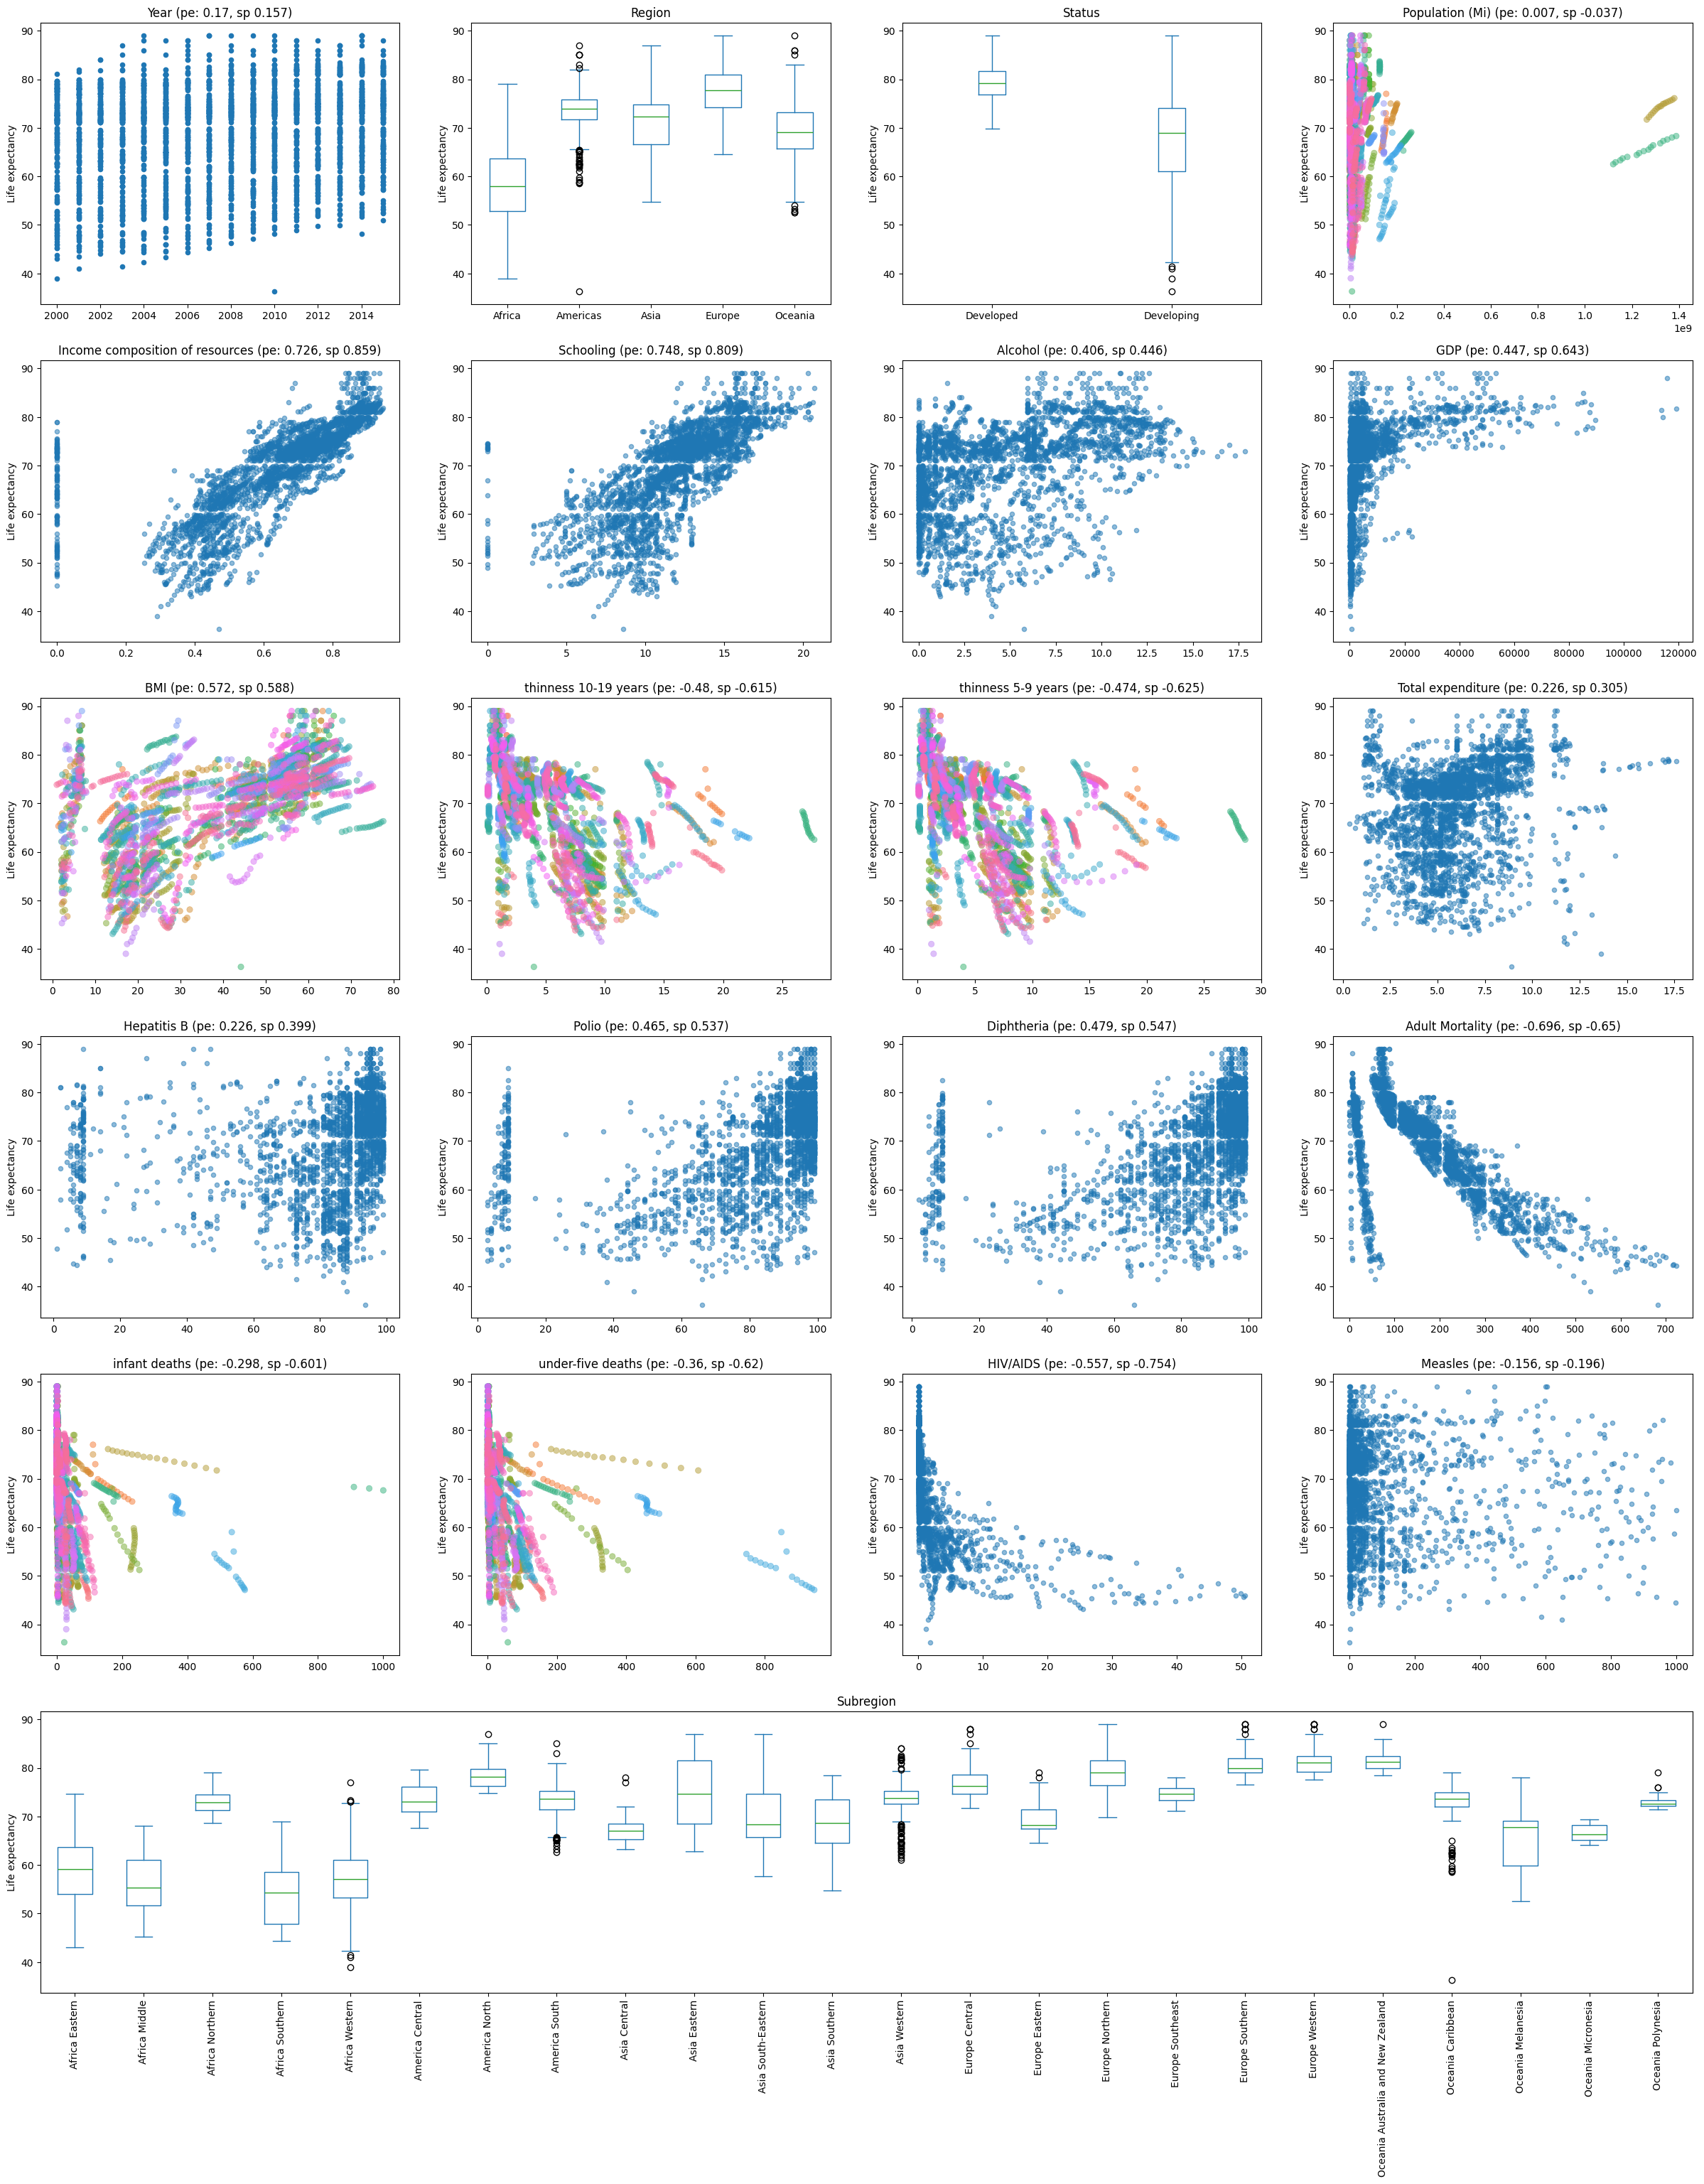

In [5]:

fig = plt.figure(figsize=(30, 6*6))
grid = gridspec.GridSpec(6, 4, figure=fig)

# 1° linha
ax1 = fig.add_subplot(grid[0, 0])
df[['Year','Life expectancy']].plot.scatter(x='Year', y='Life expectancy', ax=ax1)
pearson_corr, _ = stats.pearsonr(df['Year'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Year'], df['Life expectancy'])
ax1.set_title(f'Year (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax1.set_xlabel(None)
ax1.set_ylabel('Life expectancy')

ax2 = fig.add_subplot(grid[0, 1])
df[['region','Life expectancy']].plot.box(by='region', ax=ax2)
ax2.set_title('Region')
ax2.set_xlabel(None)
ax2.set_ylabel('Life expectancy')

ax3 = fig.add_subplot(grid[0, 2])
df[['Status','Life expectancy']].plot.box(by='Status', ax=ax3)
ax3.set_title('Status')
ax3.set_xlabel(None)
ax3.set_ylabel('Life expectancy')

ax4 = fig.add_subplot(grid[0, 3])
# df[['Population','Life expectancy']].plot.scatter(x='Population', y='Life expectancy', alpha=.5, ax=ax4)
sns.scatterplot(x='Population', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax4)
ax4.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['Population'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Population'], df['Life expectancy'])
ax4.set_title(f'Population (Mi) (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax4.set_xlabel(None)
ax4.set_ylabel('Life expectancy')

# 2° linha
ax5 = fig.add_subplot(grid[1, 0])
df[['Income composition of resources','Life expectancy']].plot.scatter(x='Income composition of resources', y='Life expectancy', alpha=.5, ax=ax5)
pearson_corr, _ = stats.pearsonr(df['Income composition of resources'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Income composition of resources'], df['Life expectancy'])
ax5.set_title(f'Income composition of resources (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax5.set_xlabel(None)
ax5.set_ylabel('Life expectancy')

ax6 = fig.add_subplot(grid[1, 1])
df[['Schooling','Life expectancy']].plot.scatter(x='Schooling', y='Life expectancy', alpha=.5, ax=ax6)
pearson_corr, _ = stats.pearsonr(df['Schooling'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Schooling'], df['Life expectancy'])
ax6.set_title(f'Schooling (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax6.set_xlabel(None)
ax6.set_ylabel('Life expectancy')

ax7 = fig.add_subplot(grid[1, 2])
df[['Alcohol','Life expectancy']].plot.scatter(x='Alcohol', y='Life expectancy', alpha=.5, ax=ax7)
pearson_corr, _ = stats.pearsonr(df['Alcohol'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Alcohol'], df['Life expectancy'])
ax7.set_title(f'Alcohol (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax7.set_xlabel(None)
ax7.set_ylabel('Life expectancy')

ax8 = fig.add_subplot(grid[1, 3])
df[['GDP','Life expectancy']].plot.scatter(x='GDP', y='Life expectancy', alpha=.5, ax=ax8)
pearson_corr, _ = stats.pearsonr(df['GDP'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['GDP'], df['Life expectancy'])
ax8.set_title(f'GDP (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax8.set_xlabel(None)
ax8.set_ylabel('Life expectancy')

# 3° linha
ax9 = fig.add_subplot(grid[2, 0])
# df[['BMI','Life expectancy']].plot.scatter(x='BMI', y='Life expectancy', alpha=.5, ax=ax9)
sns.scatterplot(x='BMI', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax9)
ax9.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['BMI'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['BMI'], df['Life expectancy'])
ax9.set_title(f'BMI (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax9.set_xlabel(None)
ax9.set_ylabel('Life expectancy')

ax10 = fig.add_subplot(grid[2, 1])
# df[['thinness 10-19 years','Life expectancy']].plot.scatter(x='thinness 10-19 years', y='Life expectancy', alpha=.5, ax=ax10)
sns.scatterplot(x='thinness 10-19 years', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax10)
ax10.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['thinness 10-19 years'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['thinness 10-19 years'], df['Life expectancy'])
ax10.set_title(f'thinness 10-19 years (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax10.set_xlabel(None)
ax10.set_ylabel('Life expectancy')

ax11 = fig.add_subplot(grid[2, 2])
# df[['thinness 5-9 years','Life expectancy']].plot.scatter(x='thinness 5-9 years', y='Life expectancy', alpha=.5, ax=ax11)
sns.scatterplot(x='thinness 5-9 years', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax11)
ax11.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['thinness 5-9 years'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['thinness 5-9 years'], df['Life expectancy'])
ax11.set_title(f'thinness 5-9 years (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax11.set_xlabel(None)
ax11.set_ylabel('Life expectancy')

ax12 = fig.add_subplot(grid[2, 3])
df[['Total expenditure','Life expectancy']].plot.scatter(x='Total expenditure', y='Life expectancy', alpha=.5, ax=ax12)
pearson_corr, _ = stats.pearsonr(df['Total expenditure'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Total expenditure'], df['Life expectancy'])
ax12.set_title(f'Total expenditure (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax12.set_xlabel(None)
ax12.set_ylabel('Life expectancy')

# 4° linha
ax13 = fig.add_subplot(grid[3, 0])
df[['Hepatitis B','Life expectancy']].plot.scatter(x='Hepatitis B', y='Life expectancy', alpha=.5, ax=ax13)
pearson_corr, _ = stats.pearsonr(df['Hepatitis B'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Hepatitis B'], df['Life expectancy'])
ax13.set_title(f'Hepatitis B (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax13.set_xlabel(None)
ax13.set_ylabel('Life expectancy')

ax14 = fig.add_subplot(grid[3, 1])
df[['Polio','Life expectancy']].plot.scatter(x='Polio', y='Life expectancy', alpha=.5, ax=ax14)
pearson_corr, _ = stats.pearsonr(df['Polio'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Polio'], df['Life expectancy'])
ax14.set_title(f'Polio (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax14.set_xlabel(None)
ax14.set_ylabel('Life expectancy')

ax15 = fig.add_subplot(grid[3, 2])
df[['Diphtheria','Life expectancy']].plot.scatter(x='Diphtheria', y='Life expectancy', alpha=.5, ax=ax15)
pearson_corr, _ = stats.pearsonr(df['Diphtheria'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Diphtheria'], df['Life expectancy'])
ax15.set_title(f'Diphtheria (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax15.set_xlabel(None)
ax15.set_ylabel('Life expectancy')

ax16 = fig.add_subplot(grid[3, 3])
df[['Adult Mortality','Life expectancy']].plot.scatter(x='Adult Mortality', y='Life expectancy', alpha=.5, ax=ax16)
pearson_corr, _ = stats.pearsonr(df['Adult Mortality'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Adult Mortality'], df['Life expectancy'])
ax16.set_title(f'Adult Mortality (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax16.set_xlabel(None)
ax16.set_ylabel('Life expectancy')

# 5° linha
ax17 = fig.add_subplot(grid[4, 0])
# df[['infant deaths','Life expectancy']].plot.scatter(x='infant deaths', y='Life expectancy', alpha=.5, ax=ax17)
sns.scatterplot(x='infant deaths', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax17)
ax17.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['infant deaths'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['infant deaths'], df['Life expectancy'])
ax17.set_title(f'infant deaths (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax17.set_xlabel(None)
ax17.set_ylabel('Life expectancy')

ax18 = fig.add_subplot(grid[4, 1])
# df[['under-five deaths','Life expectancy']].plot.scatter(x='under-five deaths', y='Life expectancy', alpha=.5, ax=ax18)
sns.scatterplot(x='under-five deaths', y='Life expectancy', data=df, hue='Country', ec=None, alpha=.5, ax=ax18)
ax18.legend([],[], frameon=False) # cores são os paises, aqui não importa quem é, importa que a correlação existe dentro de Country (pais)
pearson_corr, _ = stats.pearsonr(df['under-five deaths'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['under-five deaths'], df['Life expectancy'])
ax18.set_title(f'under-five deaths (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax18.set_xlabel(None)
ax18.set_ylabel('Life expectancy')

ax19 = fig.add_subplot(grid[4, 2])
df[['HIV/AIDS','Life expectancy']].plot.scatter(x='HIV/AIDS', y='Life expectancy', alpha=.5, ax=ax19)
pearson_corr, _ = stats.pearsonr(df['HIV/AIDS'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['HIV/AIDS'], df['Life expectancy'])
ax19.set_title(f'HIV/AIDS (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax19.set_xlabel(None)
ax19.set_ylabel('Life expectancy')

ax20 = fig.add_subplot(grid[4, 3])
df[['Measles','Life expectancy']].plot.scatter(x='Measles', y='Life expectancy', alpha=.5, ax=ax20)
pearson_corr, _ = stats.pearsonr(df['Measles'], df['Life expectancy'])
spearman_corr, _ = stats.spearmanr(df['Measles'], df['Life expectancy'])
ax20.set_title(f'Measles (pe: {round(pearson_corr, 3)}, sp {round(spearman_corr, 3)})')
ax20.set_xlabel(None)
ax20.set_ylabel('Life expectancy')

# ultima linha
ax21 = fig.add_subplot(grid[5, :])
df_ = df[['subregion','Life expectancy']].copy()
df_['subregion'] = df_['subregion'].apply(lambda x: f"{' '.join(x.split()[1:])} {x.split()[0]}" if ('Asia' in x or 'Europe' in x or 'Africa' in x or 'America' in x) else f'Oceania {x}')
df_.plot.box(by='subregion', ax=ax21)
ax21.set_title('Subregion')
ax21.set_xlabel(None)
ax21.set_ylabel('Life expectancy')
ax21.tick_params(axis='x', labelrotation=90)

plt.show()

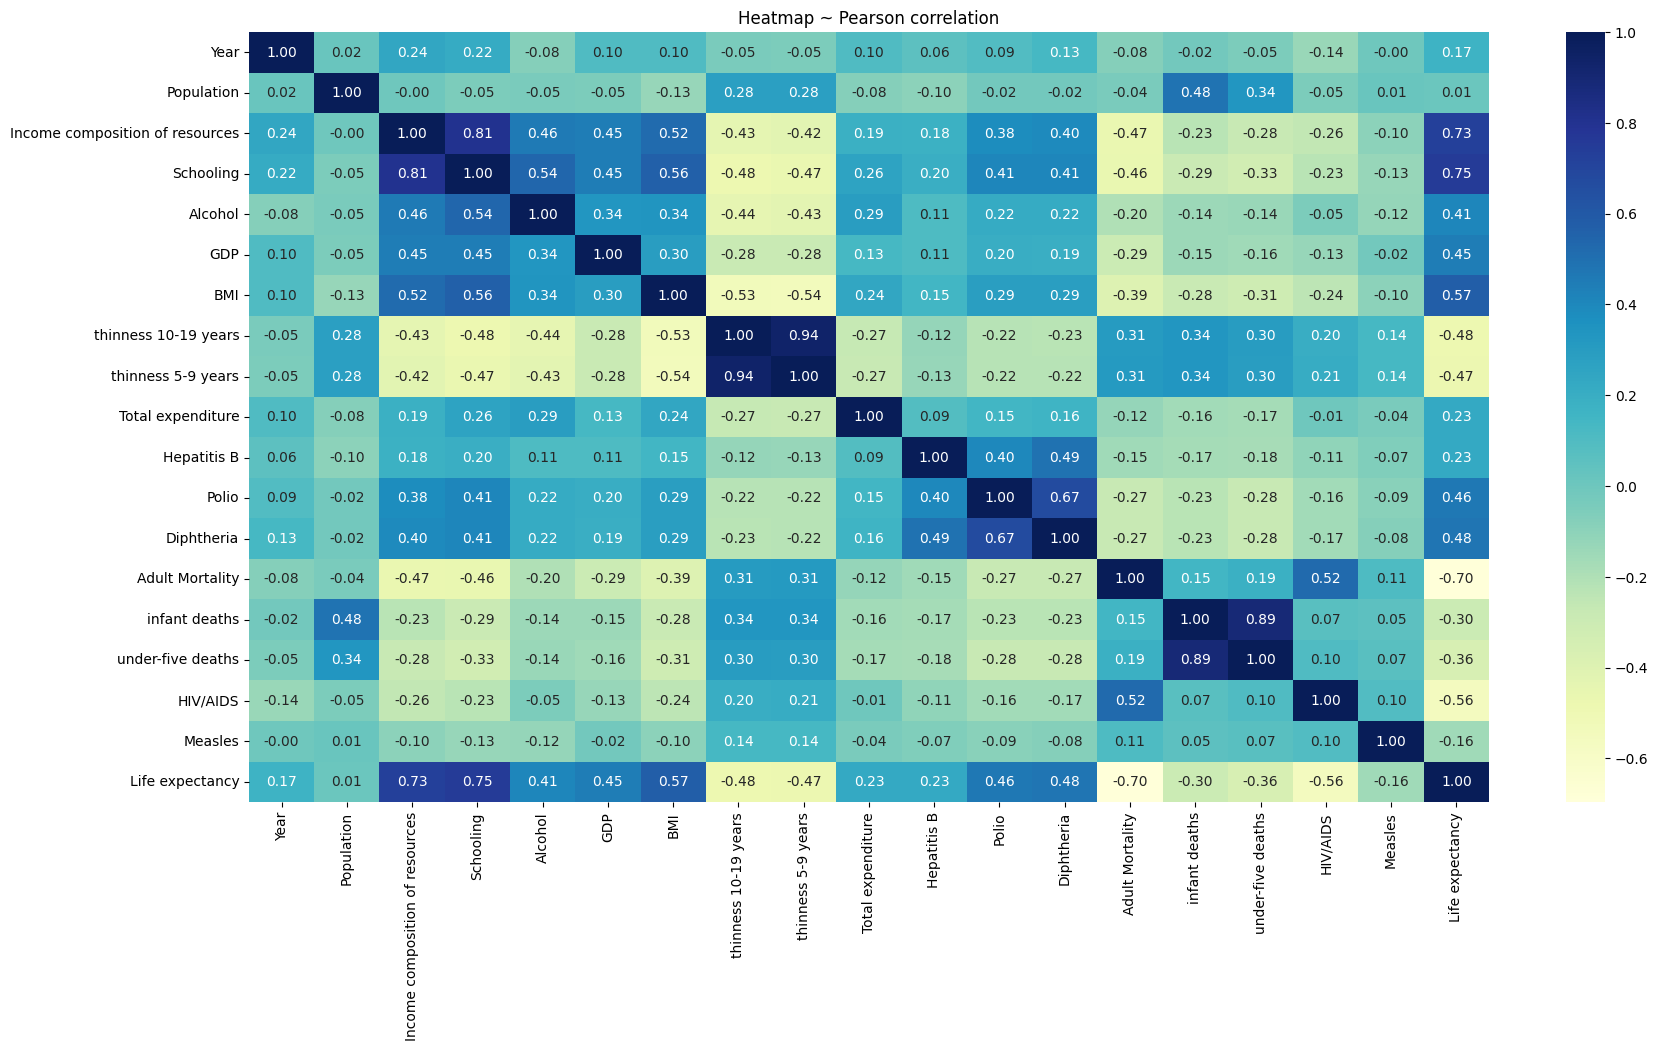

In [6]:

plt.figure(figsize=(20, 10)) # Optional: Adjust figure size
df_corr = df[[
    'Year','Population', 'Income composition of resources', 'Schooling', 'Alcohol', 'GDP', 'BMI', 'thinness 10-19 years', 'thinness 5-9 years', 'Total expenditure',
    'Hepatitis B', 'Polio', 'Diphtheria', 'Adult Mortality', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles', 'Life expectancy'
    ]].corr()
sns.heatmap(df_corr, annot=True, cmap='YlGnBu', fmt='.2f') # Add annotations and specific colormap
plt.title('Heatmap ~ Pearson correlation')
plt.show()

*OBS.:* as cores dos pontos nos graficos de disperção coloridos são países, a ideia é visualizar que no geral a correlação pode ser fraca/media/não existir mas individualmente por país existe fortemente.

In [7]:

print('Testes de Hipoteses ~ médias e correlações')
a = .05

#----------- médias

print()
print('-- region --')
display(df.groupby('region')['Life expectancy'].mean().sort_values(ascending=False).reset_index())
# teste de hip para variancias ~ h0: var iguais, ha: var diferentes.
stat, p = stats.levene(df[df['region'] == 'Asia']['Life expectancy'], df[df['region'] == 'Europe']['Life expectancy'], df[df['region'] == 'Africa']['Life expectancy'], df[df['region'] == 'Americas']['Life expectancy'], df[df['region'] == 'Oceania']['Life expectancy'])
print('Levene', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var iguais. statistic: {stat}, p-value: {p}')
# teste de hip para medias, variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: pelo menos 1 média diferente.
hiptest = pg.welch_anova(data=df, dv='Life expectancy', between='region')
stat, p = hiptest.iloc[0]['F'], hiptest.iloc[0]['p-unc']
print('ANOVA welch', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: medias iguais: {stat}, p-value: {p}')
# teste de hip para medias (pairwise, descobrir qual media difere qual, pós teste de hip para medias), variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: médias diferentes.
hiptest = pg.pairwise_gameshowell(data=df, dv='Life expectancy', between='region')
print('PAIRWISE gameshowell ~ diferenças significativas:')
display(hiptest[hiptest['pval'] <= a]) # Asia e Oceania são as unicas estatisticamente (a 1-a de confiança) iguais.

print()
print('-- subregion --')
display(df.groupby('subregion')['Life expectancy'].mean().sort_values(ascending=False).reset_index())
# teste de hip para variancias ~ h0: var iguais, ha: var diferentes.
stat, p = stats.levene(
    df[df['subregion'] == 'Southern Asia']['Life expectancy'], 
    df[df['subregion'] == 'Southeast Europe']['Life expectancy'], 
    df[df['subregion'] == 'Northern Africa']['Life expectancy'], 
    df[df['subregion'] == 'Middle Africa']['Life expectancy'], 
    df[df['subregion'] == 'Caribbean']['Life expectancy'],
    df[df['subregion'] == 'South America']['Life expectancy'], 
    df[df['subregion'] == 'Western Asia']['Life expectancy'], 
    df[df['subregion'] == 'Australia and New Zealand']['Life expectancy'], 
    df[df['subregion'] == 'Central Europe']['Life expectancy'], 
    df[df['subregion'] == 'Eastern Europe']['Life expectancy'],
    df[df['subregion'] == 'Western Europe']['Life expectancy'], 
    df[df['subregion'] == 'Central America']['Life expectancy'], 
    df[df['subregion'] == 'Western Africa']['Life expectancy'], 
    df[df['subregion'] == 'Southern Africa']['Life expectancy'], 
    df[df['subregion'] == 'South-Eastern Asia']['Life expectancy'],
    df[df['subregion'] == 'Eastern Africa']['Life expectancy'], 
    df[df['subregion'] == 'North America']['Life expectancy'],
    df[df['subregion'] == 'Eastern Asia']['Life expectancy'], 
    df[df['subregion'] == 'Southern Europe']['Life expectancy'], 
    df[df['subregion'] == 'Northern Europe']['Life expectancy'], 
    df[df['subregion'] == 'Melanesia']['Life expectancy'],
    df[df['subregion'] == 'Central Asia']['Life expectancy'],
    df[df['subregion'] == 'Micronesia']['Life expectancy'],
    df[df['subregion'] == 'Polynesia']['Life expectancy']
    )
print('Levene', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var iguais. statistic: {stat}, p-value: {p}')
# teste de hip para medias, variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: pelo menos 1 média diferente.
hiptest = pg.welch_anova(data=df, dv='Life expectancy', between='subregion')
stat, p = hiptest.iloc[0]['F'], hiptest.iloc[0]['p-unc']
print('ANOVA welch', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: medias iguais: {stat}, p-value: {p}')
# teste de hip para medias (pairwise, descobrir qual media difere qual, pós teste de hip para medias), variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: médias diferentes.
hiptest = pg.pairwise_gameshowell(data=df, dv='Life expectancy', between='subregion')
print('PAIRWISE gameshowell ~ diferenças significativas:')
display(hiptest[hiptest['pval'] <= a]) # diversas médias estatisticamente (a 1-a de confiança) iguais.

print()
print('-- Status --')
display(df.groupby('Status')['Life expectancy'].mean().sort_values(ascending=False).reset_index())
# teste de hip para variancias ~ h0: var iguais, ha: var diferentes.
stat = np.var(df[df['Status'] == 'Developed']['Life expectancy'], ddof=1) / np.var(df[df['Status'] == 'Developing']['Life expectancy'], ddof=1)
df1, df2 = df[df['Status'] == 'Developed'].shape[0] - 1, df[df['Status'] == 'Developing'].shape[0] - 1
p = 2 * stats.f.cdf(stat, df1, df2)
print('F-test', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: var iguais. statistic: {stat}, p-value: {p}')
# teste de hip para médias, variancias pop desconhecidas e diferentes ~ h0: médias iguais, ha: médias diferentes.
stat, p = stats.ttest_ind(df[df['Status'] == 'Developed']['Life expectancy'], df[df['Status'] == 'Developing']['Life expectancy'], equal_var=False)
print('T-test', end=' ~ ')
if p <= a: print(f'existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: médias diferentes. statistic: {stat}, p-value: {p}')
else: print(f'não existe evidencias suficientes a {1-a} de confiança para rejeitar h0, portanto: médias iguais. statistic: {stat}, p-value: {p}')

#----------- correlações

scatter_graph_cols = [
    'Year','Population', 'Income composition of resources', 'Schooling', 'Alcohol', 'GDP', 'BMI', 'thinness 10-19 years', 'thinness 5-9 years', 'Total expenditure',
    'Hepatitis B', 'Polio', 'Diphtheria', 'Adult Mortality', 'infant deaths', 'under-five deaths', 'HIV/AIDS', 'Measles']
colored_scatter_graph_cols = ['Population', 'BMI', 'thinness 10-19 years', 'thinness 5-9 years', 'infant deaths', 'under-five deaths']
for col in scatter_graph_cols:
    print()
    print(f'-- {col} --')
    pearson_corr, pearson_p = stats.pearsonr(df[col], df['Life expectancy'])
    spearman_corr, spearman_p = stats.spearmanr(df[col], df['Life expectancy'])
    print(f"Correlação de Pearson: {pearson_corr}, {'fraca' if pearson_corr < .5 else 'forte'} e {'significante' if spearman_p <= a else 'não significante'} e p-value: {pearson_p}")
    print(f"Correlação de Spearman: {spearman_corr}, {'fraca' if spearman_corr < .5 else 'forte'} e {'significante' if spearman_p <= a else 'não significante'}, p-value: {spearman_p}")
    if col in colored_scatter_graph_cols:
        print(f'obs.: é possiver observar no grafico de dispersão pequenas linhas (country) com correlação positiva, portanto a correlação entre {col} e Life expectancy existe dentro de country.')

Testes de Hipoteses ~ médias e correlações

-- region --


,region,Life expectancy
0,Europe,77.422561
1,Americas,73.485417
2,Asia,71.050284
3,Oceania,69.832386
4,Africa,58.786111


Levene ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: var diferentes. statistic: 79.11512769505129, p-value: 8.140550402398385e-64
ANOVA welch ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: 812.2771059060265, p-value: 1.7348738056432758e-299
PAIRWISE gameshowell ~ diferenças significativas:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Africa,Americas,58.786111,73.485417,-14.699306,0.334943,-43.885965,1376.109796,0.000000e+00,-2.126797
1,Africa,Asia,58.786111,71.050284,-12.264173,0.351494,-34.891530,1545.738060,2.964295e-14,-1.715283
2,Africa,Europe,58.786111,77.422561,-18.636450,0.331871,-56.155666,1442.196073,0.000000e+00,-2.722543
3,Africa,Oceania,58.786111,69.832386,-11.046275,0.630315,-17.524999,263.221235,0.000000e+00,-1.384968
4,Americas,Asia,73.485417,71.050284,2.435133,0.292391,8.328333,1229.869430,1.593170e-13,0.460982
5,Americas,Europe,73.485417,77.422561,-3.937144,0.268483,-14.664421,1160.062016,0.000000e+00,-0.849454
6,Americas,Oceania,73.485417,69.832386,3.653030,0.599368,6.094805,216.630949,4.941028e-08,0.679652
7,Asia,Europe,71.050284,77.422561,-6.372277,0.288867,-22.059535,1336.964332,0.000000e+00,-1.188223
9,Europe,Oceania,77.422561,69.832386,7.590175,0.597657,12.699892,214.432007,0.000000e+00,1.382596



-- subregion --


,subregion,Life expectancy
0,Australia and New Zealand,81.575000
1,Western Europe,81.386458
2,Southern Europe,80.917708
3,Northern Europe,78.915000
4,North America,78.489583
5,Central Europe,77.034375
6,Southeast Europe,74.617361
7,Eastern Asia,74.473750
8,Central America,73.466964
9,Western Asia,73.391667


Levene ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: var diferentes. statistic: 27.521212633117823, p-value: 9.265353819525927e-107
ANOVA welch ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: pelo menos 1 média diferente. statistic: 356.8578327284025, p-value: 0.0
PAIRWISE gameshowell ~ diferenças significativas:


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Australia and New Zealand,Caribbean,81.575000,72.692614,8.882386,0.559092,15.887177,93.765857,0.000000e+00,1.876784
1,Australia and New Zealand,Central America,81.575000,73.466964,8.108036,0.517769,15.659570,70.972014,1.598721e-14,2.572372
2,Australia and New Zealand,Central Asia,81.575000,67.030000,14.545000,0.505895,28.751028,64.233367,0.000000e+00,5.664574
3,Australia and New Zealand,Central Europe,81.575000,77.034375,4.540625,0.545191,8.328506,80.535616,4.790486e-10,1.386855
4,Australia and New Zealand,Eastern Africa,81.575000,59.408456,22.166544,0.605123,36.631444,125.574943,6.461498e-14,3.171568
...,...,...,...,...,...,...,...,...,...,...
270,Southern Europe,Western Africa,80.917708,57.383750,23.533958,0.519113,45.334951,332.508811,0.000000e+00,4.025017
271,Southern Europe,Western Asia,80.917708,73.391667,7.526042,0.394673,19.069073,250.770141,5.773160e-14,1.971684
273,Western Africa,Western Asia,57.383750,73.391667,-16.007917,0.505634,-31.659095,399.059067,1.462164e-13,-2.885530
274,Western Africa,Western Europe,57.383750,81.386458,-24.002708,0.520921,-46.077421,332.006058,3.019807e-14,-4.102094



-- Status --


,Status,Life expectancy
0,Developed,79.197852
1,Developing,67.111465


F-test ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: var diferentes. statistic: 0.1905111916973935, p-value: 4.2290319276406295e-89
T-test ~ existe evidencias suficientes a 0.95 de confiança para rejeitar h0, portanto: médias diferentes. statistic: 47.86840603524898, p-value: 2e-323

-- Year --
Correlação de Pearson: 0.17003302485909022, fraca e significante e p-value: 1.9642797530309915e-20
Correlação de Spearman: 0.15716516379926856, fraca e significante, p-value: 1.1895463297159208e-17

-- Population --
Correlação de Pearson: 0.0067984040500003486, fraca e significante e p-value: 0.713085313285896
Correlação de Spearman: -0.03659061951444941, fraca e significante, p-value: 0.04772910739977108
obs.: é possiver observar no grafico de dispersão pequenas linhas (country) com correlação positiva, portanto a correlação entre Population e Life expectancy existe dentro de country.

-- Income composition of resources --
Correlação de Pearson: 0.7258308935082

#### *Multivariate* Analysis ~ versus **Life Expectancy**

In [8]:

df_rl = df.copy()
df_rl = df_rl.drop(['Country'], axis=1)               # muitos valores unicos, tal coluna foi usada para gerar colunas com poucos valores unicos (region, subregion).
df_rl = df_rl.rename(columns={'Status':'Developed'})  # 2 valores unicos em status, tal coluna sera convertida para coluna binaria pois os dois valoes unicos são opostos entre si.
df_rl.columns = [col.replace(' ', '_').replace('/','_').replace('-','_') for col in df_rl.columns]

df_rl = df_rl.drop([                                  # colunas causando multicolinearidade
    'region', 'thinness_5_9_years', 'infant_deaths'
    ], axis=1)                      

print('dummies')
dummies = []
# classic categ dummies
dummies_cols = ['subregion'] # 'region'
dummies += dummies_cols
default_dimmies_cols = []
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for i, val in enumerate(df_rl[col].unique()):
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}_"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
        if i == 0: default_dimmies_cols.append(col_name)
    df_rl = df_rl.drop(col, axis=1)
df_rl = df_rl.drop(default_dimmies_cols, axis=1) # deletando colunas redundantes
# yes or no dummies
dummies_cols = ['Developed']
dummies += dummies_cols
for col in dummies_cols:
    df_rl[col] = (df_rl[col]=='Developed').astype(int)

# padronizando valores
scaler = StandardScaler()
df_rl_values = scaler.fit_transform(df_rl)
df_rl = pd.DataFrame(df_rl_values, columns=df_rl.columns)

# train/test split
df_test = df_rl.sample(int(df_rl.shape[0]*.2), random_state=42)
df_rl = df_rl.loc[[i for i in df_rl.index if i not in df_test.index]]
print(f'\ntest: {df_test.shape[0]/(df_test.shape[0]+df_rl.shape[0])}, train: {df_rl.shape[0]/(df_test.shape[0]+df_rl.shape[0])}')

target = 'Life_expectancy'
features = [col for col in df_rl.columns if target not in col]
features_continuas = [col for col in features if not len([dummie for dummie in dummies if dummie in col])]

print()
print('random train example:')
display(df_rl.sample().iloc[0])

dummies
default for subregion: Southern Asia

test: 0.19979508196721313, train: 0.8002049180327869

random train example:


Year                                    0.542326
Developed                               2.172268
Population                             -0.231086
Income_composition_of_resources         1.480025
Schooling                               1.633093
Alcohol                                 0.517612
GDP                                     6.073693
BMI                                     1.046381
thinness_10_19_years                   -0.948839
Total_expenditure                       1.378140
Hepatitis_B                             0.551266
Polio                                   0.447279
Diphtheria                              0.451376
Adult_Mortality                        -0.795009
under_five_deaths                      -0.371833
HIV_AIDS                               -0.324055
Measles                                -0.453327
Life_expectancy                         1.236586
subregion_Southeast_Europe_            -0.227429
subregion_Northern_Africa_             -0.167600
subregion_Middle_Afr

In [9]:

formula = f"{target} ~ {' + '.join(features)}"
model = smf.ols(formula=formula, data=df_rl)
res = model.fit()
res.summary()

### Omnibus 
# h0: todos os coeficientes (excluindo o interpecto) são iguais a zero, i.e., são insignificantes -> modelo irrelevante.
# ha: pelo menos 1 coeficiente é diferente de zero, i.e., pelo menos 1 coeficiente significante -> modelo não irrelevante.
### Jarque-Bera
# h0: distribuição dos residuos seguem uma normal.
# ha: distribuição dos residuos não seguem uma normal.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     400.4
Date:                Sat, 13 Dec 2025   Prob (F-statistic):               0.00
Time:                        17:29:34   Log-Likelihood:                -899.02
No. Observations:                2343   AIC:                             1880.
Df Residuals:                    2302   BIC:                             2116.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -0.0044      0.007     -0.598      0.550      -0.019       0.010
Year                                     0.0340      0.009      3.991      0.000       0.017       0.051
Developed                                0.0305      0.014      2.138      0.033       0.003       0.059
Population                               0.0577      0.010      6.064      0.000       0.039       0.076
Income_composition_of_resources          0.1077      0.014      7.756      0.000       0.080       0.135
Schooling                                0.1802      0.016     11.468      0.000       0.149       0.211
Alcohol                                 -0.0013      0.013     -0.103      0.918      -0.027       0.024
GDP                                      0.0694      0.010      7.301      0.000       0.051       0.088
BMI                                      0.0160      0.012      1.376      0.169      -0.007       0.039
thinness_10_19_years                    -0.0621      0.013     -4.843      0.000      -0.087      -0.037
Total_expenditure                       -0.0088      0.009     -1.014      0.311      -0.026       0.008
Hepatitis_B                             -0.0251      0.009     -2.845      0.004      -0.042      -0.008
Polio                                    0.0588      0.010      5.644      0.000       0.038       0.079
Diphtheria                               0.0611      0.011      5.510      0.000       0.039       0.083
Adult_Mortality                         -0.1624      0.011    -15.427      0.000      -0.183      -0.142
under_five_deaths                       -0.0817      0.009     -9.336      0.000      -0.099      -0.065
HIV_AIDS                                -0.2468      0.013    -19.295      0.000      -0.272      -0.222
Measles                                 -0.0161      0.008     -2.048      0.041      -0.032      -0.001
subregion_Southeast_Europe_             -0.0050      0.014     -0.361      0.718      -0.032       0.022
subregion_Northern_Africa_              -0.0111      0.011     -1.015      0.310      -0.032       0.010
subregion_Middle_Africa_                -0.1884      0.013    -14.097      0.000      -0.215      -0.162
subregion_Caribbean_                    -0.0063      0.015     -0.432      0.666      -0.035       0.022
subregion_South_America_                -0.0259      0.015     -1.675      0.094      -0.056       0.004
subregion_Western_Asia_                 -0.0186      0.015     -1.231      0.218      -0.048       0.011
subregion_Australia_and_New_Zealand_     0.0063      0.010      0.607      0.544      -0.014       0.027
subregion_Central_Europe_               -0.0179      0.014     -1.240      0.215      -0.046       0.010
subregion_Eastern_Europe_             

performance (train):
train RMSE: 0.35514313385132235, MAPE: 1.0673935800526217
test RMSE: 0.3502739906526524, MAPE: 1.4029808328940265


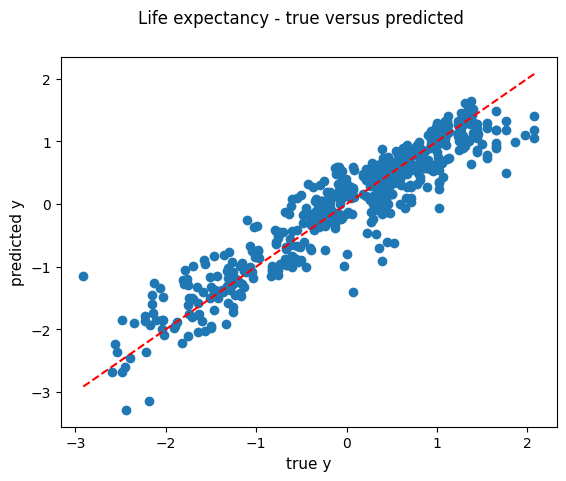

In [10]:

print('performance (train):')

y_true = df_rl['Life_expectancy'].values
y_pred = res.predict(df_rl.drop('Life_expectancy', axis=1)).values

mse = mean_squared_error(y_true, y_pred)
train_rmse = np.sqrt(mse)
train_mape = mean_absolute_percentage_error(y_true, y_pred)

y_true = df_test['Life_expectancy'].values
y_pred = res.predict(df_test.drop('Life_expectancy', axis=1)).values

mse = mean_squared_error(y_true, y_pred)
test_rmse = np.sqrt(mse)
test_mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'train RMSE: {train_rmse}, MAPE: {train_mape}')
print(f'test RMSE: {test_rmse}, MAPE: {test_mape}')

plt.scatter(x=y_true, y=y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')

plt.xlabel('true y', fontsize=11)
plt.ylabel('predicted y', fontsize=11)
plt.suptitle('Life expectancy - true versus predicted')

plt.show()

1. ***Os diversos fatores preditivos escolhidos inicialmente realmente afetam a expectativa de vida? Quais são as variáveis preditoras que de fato influenciam a expectativa de vida?***

As variaveis preditoras significantes que influenciam a expectativa de vida são:
- Year, positivamente (imagino que seja uma variavel proxy pra outra variavel).
- Developed, positivamente.
- Population, positivamente (imagino que seja uma variavel proxy pra outra variavel).
- Income_composition_of_resources, positivamente.
- Schooling, positivamente. (mais impactante ~ coef: 0.1802)
- GDP, positivamente.
- Polio, positivamente.
- Diphtheria, positivamente.
- Polio, positivamente.
- Diphtheria, positivamente.
- Measles, negativamente.
- HIV_AIDS, negativamente. (mais impactante ~ coef: -0.2468)
- under_five_deaths, negativamente.
- Adult_Mortality, negativamente.
- thinness_10_19_years, negativamente.
- Hepatitis_B, negativamente, tal variavel deveria influenciar positivamente, logo imagino que possa existir uma variavel de confusão por trás.

-- dummies *subregion* sobre comparação a Southern Asia -- 
- North_America, positivamente. (mais impactante ~ coef: 0.0419)
- Southern_Europe, positivamente.
- Middle_Africa, negativamente.
- Eastern_Europe, negativamente.
- Western_Africa, negativamente. (mais impactante ~ coef: -0.2174)
- Southern_Africa, negativamente.
- South_Eastern_Asia, negativamente.
- Eastern_Africa, negativamente.
- Melanesia, negativamente.
- Central_Asia, negativamente.
- Micronesia, negativamente.

variaveis *não* significantes:
- Alcohol, muito irrelevante.
- BMI.
- Total_expenditure, p-value: 0.311, tal variavel deveria ser fortemente relacionada com a expectativa de vida, será que os gastos com saudes acontecem de forma errada ("sem inteligência")?

-- dummies *subregion* sobre comparação a Southern Asia -- 
- Southeast_Europe.
- Northern_Africa.
- Caribbean.
- South_America.
- Western_Asia.
- Australia_and_New_Zealand.
- Central_Europe.
- Western_Europe.
- Central_America.
- Eastern_Asia.
- Northern_Europe.
- Polynesia.

<br>

2. ***Um país com expectativa de vida baixa (inferior a 65 anos) deveria aumentar seus gastos com saúde para melhorar sua longevidade média?***

Depende, dados dizem que o **percentual de gosto do governo gasto com saude** não influencia significavelmente a *expectativa de vida*, porem vimos que vacinação de **Diphtheria** e **Polio** em crianças influenciam positivamente (e significavelmente) a *expectativa de vida*. Com isso imagino que o gasto com saude tenha que ser "inteligente" (mais estratégico) e não apenas por gastar.

<br>

3. ***Como as taxas de mortalidade infantil e adulta afetam a expectativa de vida?***

Afetam negativamente a *expectativa de vida*, sendo a mortalidade adulta (2x+) mais impactante.

<br>

4. **A expectativa de vida tem correlação positiva ou negativa com hábitos alimentares, estilo de vida, prática de exercícios, tabagismo, consumo de álcool etc.?**

O dataset não contem dados exatos para responder tal pergunta, porem usando as variaveis **thinness_10_19_years** e **thinness_5_9_years** como proxy de habitos saudaveis/não saudaveis (magreza reflete habitos não saudaveis), vemos que habitos não saudaveis influenciam negativamete (e significavelmente) a expectativa de vida.

<br>

5. **Qual é o impacto da escolaridade na longevidade humana?**

Impacto posito e o maior das variaveis que impactam positivamente, outro insight que fortifica que a humanidade precisa fazer coisas mais "inteligentes". Pode também mostrar que a escolarização esta sendo bem administrada pelo governo para influenciar a *expectativa de vida*.

<br>

6. **A expectativa de vida apresenta relação positiva ou negativa com o consumo de álcool?**

Consumo de álcool é irrelevante para influenciar a expectativa de vida.

<br>

7. **Países densamente povoados tendem a ter expectativa de vida mais baixa?**

Não, tendem a ter expectativa de vida mais alta. 

<br>

8. **Qual é o impacto da cobertura vacinal (imunização) sobre a expectativa de vida?**

Positivo **Diphtheria** e **Polio** para e nagativo para **Hepatitis_B**, sendo, em módulo, o coef de **Hepatitis_B** o menor (menos impactante) e **Diphtheria** o maior (mais impactante).


###### **Premissas regressão linear para inferencia** ~ OK

In [11]:
# premissa 1: LINEARIDADE -- OK

In [12]:
# premissa 2: MÉDIA DOS RESIDUOS TENDE A ZERO -- OK
print('média dos residuos:', res.resid.mean())

média dos residuos: 3.1539242218971585e-16


pearson and spearman correlation between residue and...


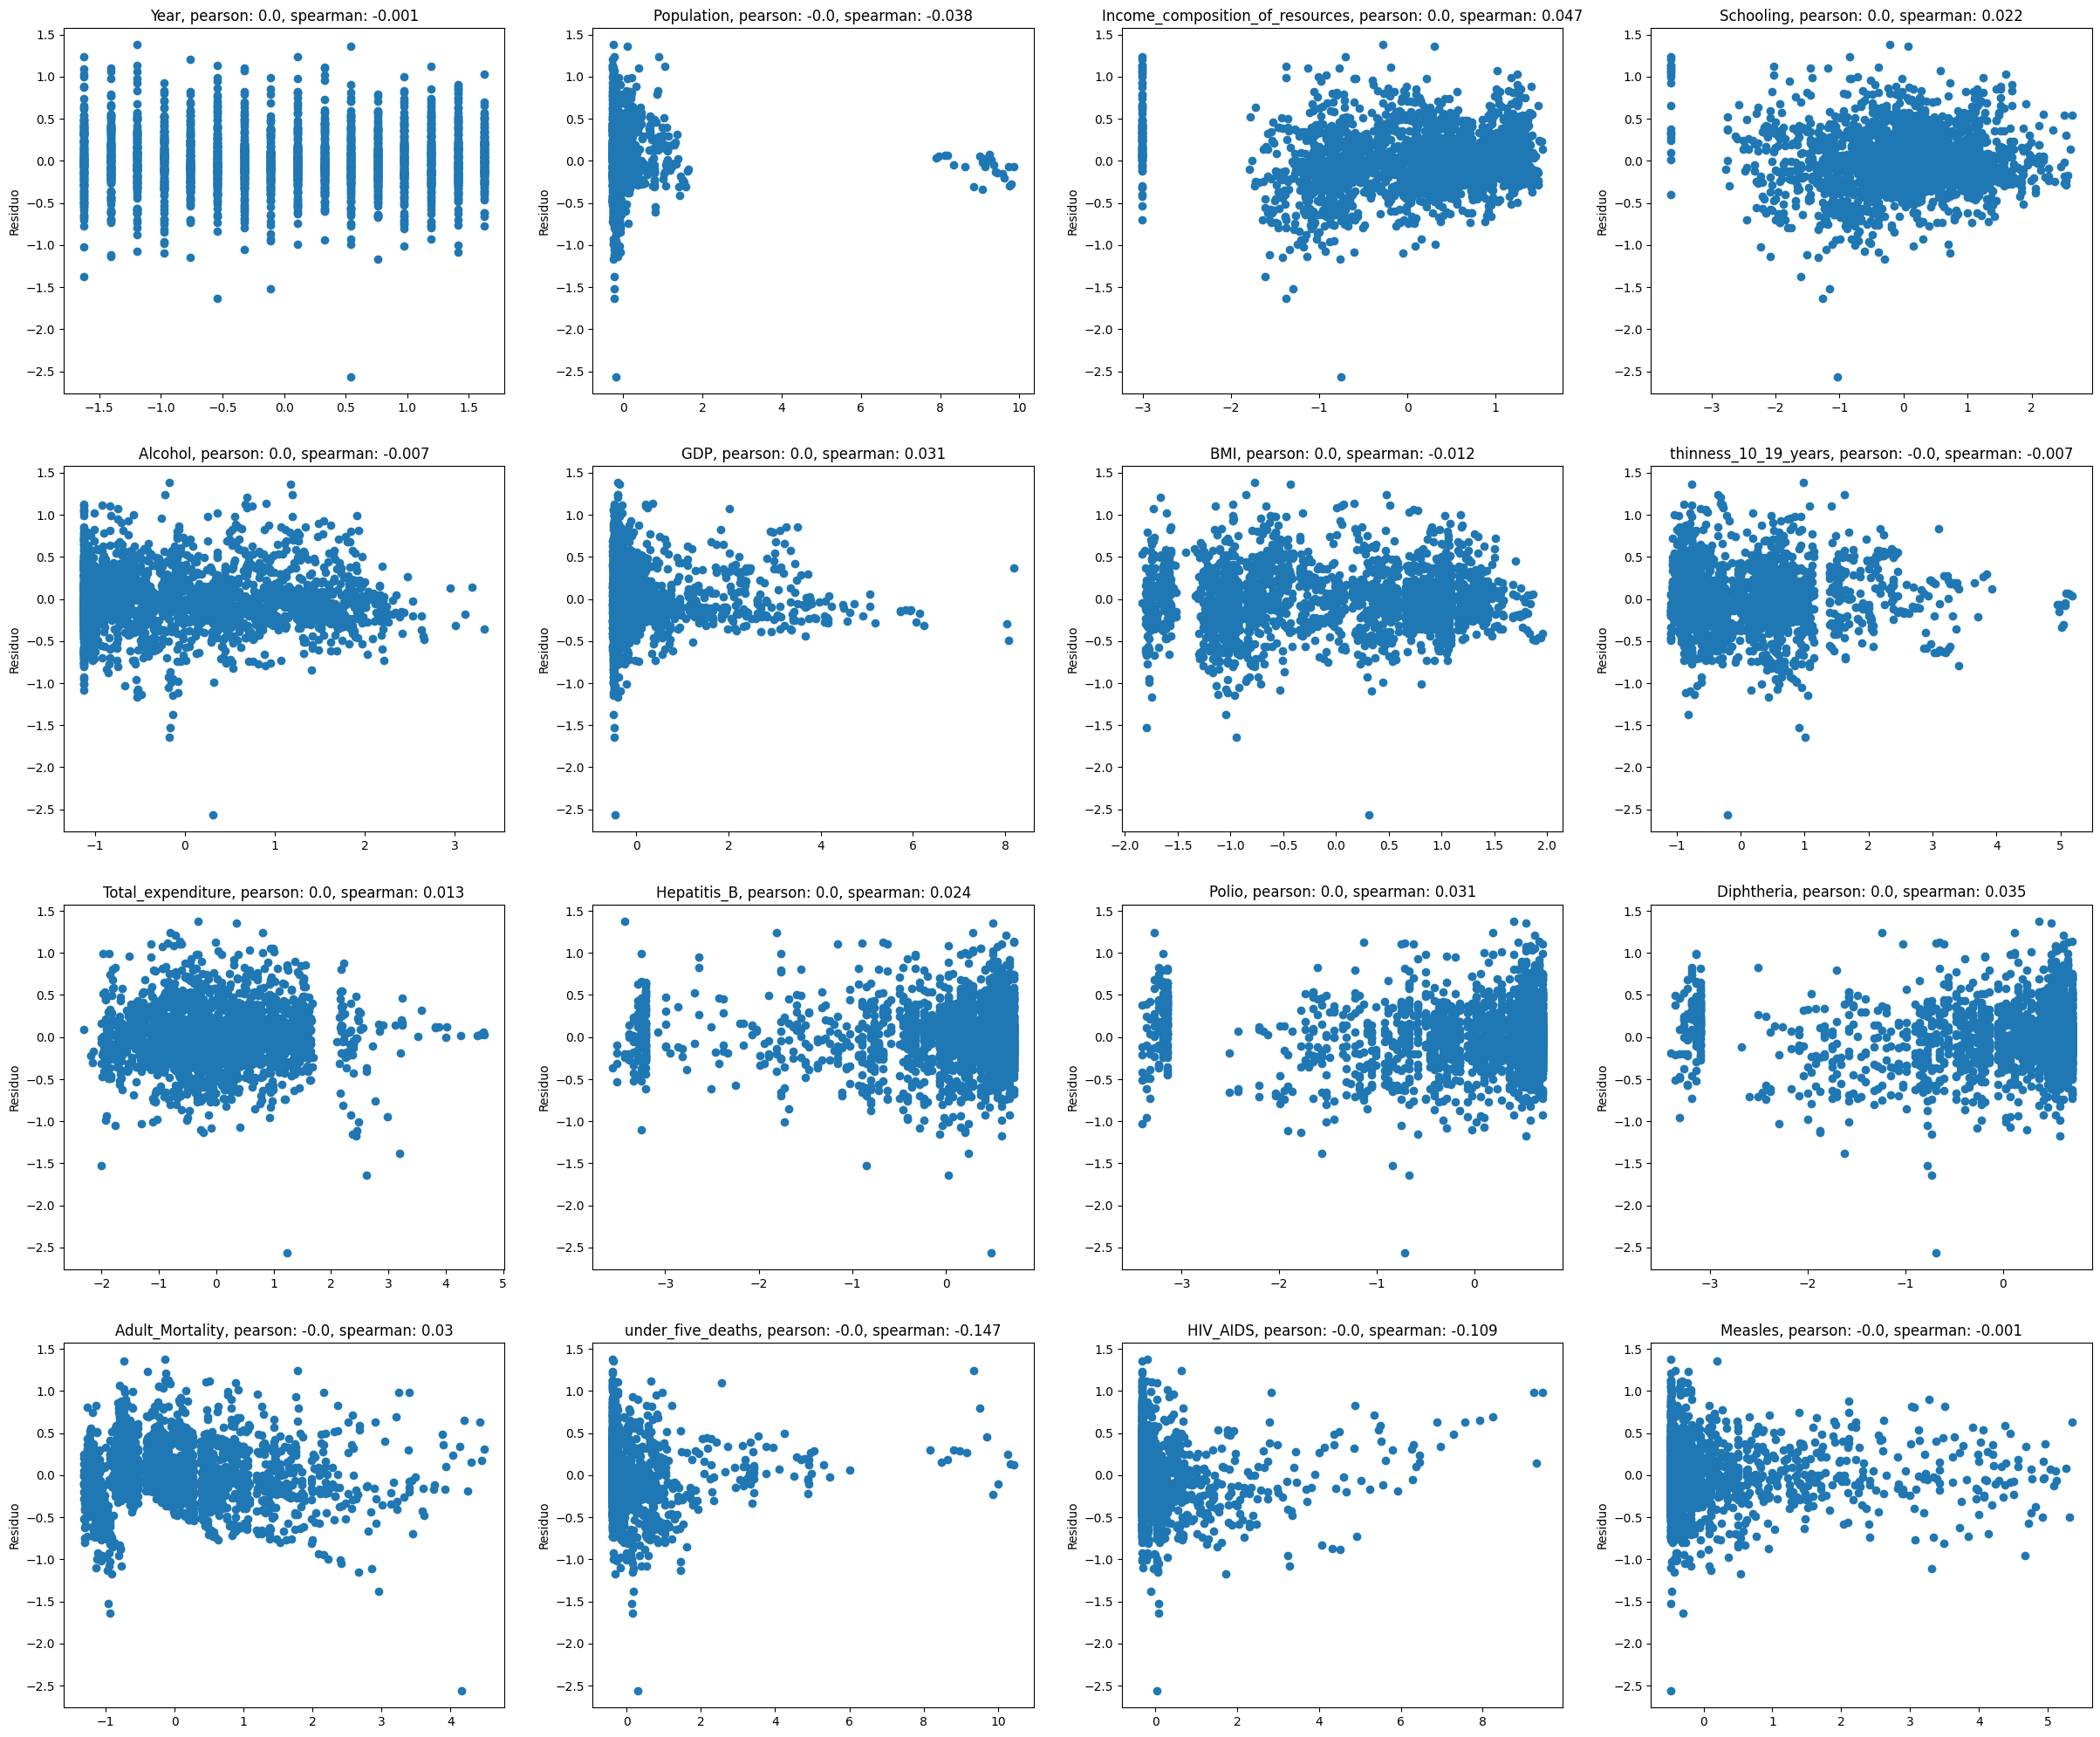

In [13]:
# EXOGENEIDADE: premissa 3: RESIDUO NÃO TEM CORRELAÇÃO COM NENHUMA FEATURE -- OK
df_rl['residuo'] = res.resid

plt.close('all')
fig, axs = plt.subplots(4, 4, figsize=(30, 25))
for i, col in enumerate(features_continuas):
    idy = i//4
    idx = i%4

    pearson_corr, _ = stats.pearsonr(df_rl[col], df_rl['residuo'])
    spearman_corr, _ = stats.spearmanr(df_rl[col], df_rl['residuo'])

    axs[idy][idx].scatter(x=df_rl[col], y=df_rl['residuo'])
    axs[idy][idx].set_title(f'{col}, pearson: {round(pearson_corr, 3)}, spearman: {round(spearman_corr, 3)}')
    axs[idy][idx].set_xlabel(None)
    axs[idy][idx].set_ylabel('Residuo')

print('pearson and spearman correlation between residue and...')
plt.show()
## OK

pearson: 0.09515580190189132, spearman: 0.11541082490121608


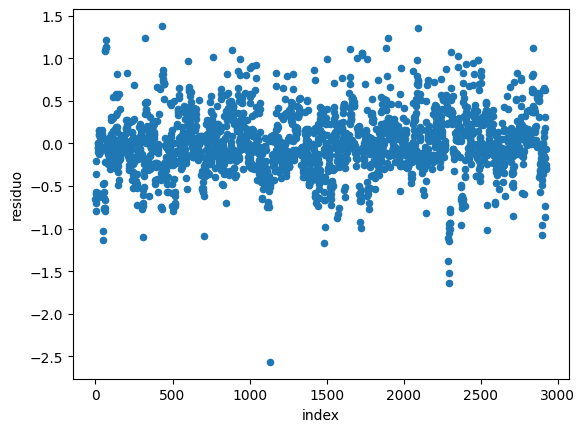

In [14]:
# premissa 4: AUSENCIA DE AUTO CORRELAÇÃO NOS RESIDOS -- OK
indexes = list(range(0, len(df_rl)))

pearson_corr, _ = stats.pearsonr(df_rl['residuo'], indexes)
spearman_corr, _ = stats.spearmanr(df_rl['residuo'], indexes)

print(f'pearson: {pearson_corr}, spearman: {spearman_corr}')
df_rl[['residuo']].reset_index().plot.scatter(x='index', y='residuo'); 

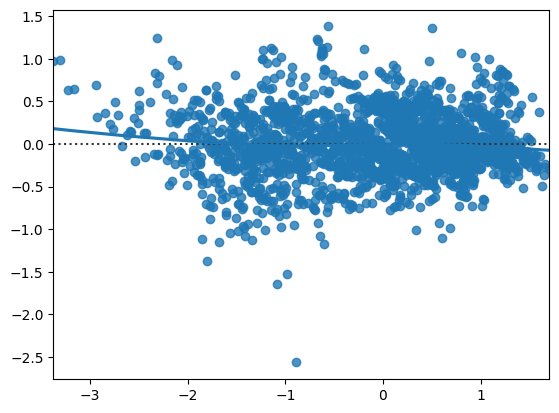

In [15]:
# HOMOCEDASTICIDADE: premissa 5: CONSTANCIA NA VARIAÇÃO DOS RESIDUOS NA DIREÇÃO DO TARGET PREVISTO -- OK
sns.residplot(x=res.fittedvalues, y=res.resid, lowess=True);

,Feature,VIF
0,Year,1.188301
1,Population,1.247328
2,Income_composition_of_resources,3.182304
3,Schooling,3.753344
4,Alcohol,1.739822
5,GDP,1.341188
6,BMI,1.755688
7,thinness_10_19_years,1.774355
8,Total_expenditure,1.181661
9,Hepatitis_B,1.330435


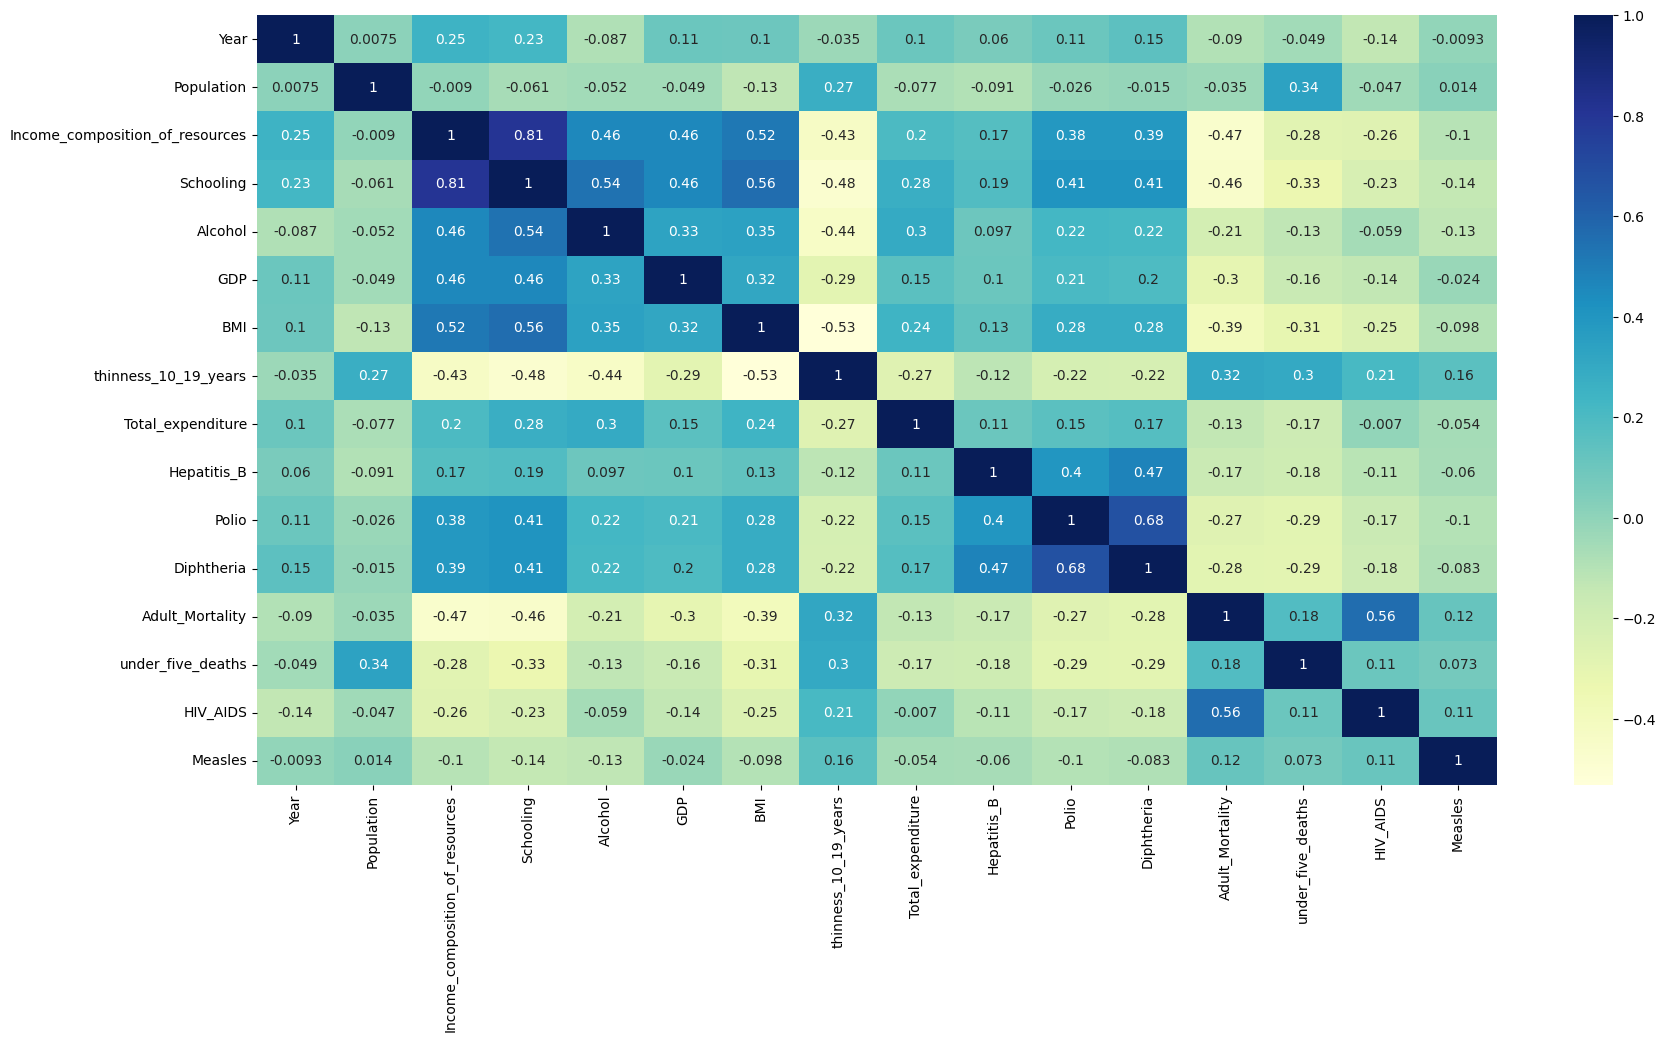

In [16]:
# premissa 6: AUSENSIA DE MULTICOLINEARIDIADE -- OK
# removida features com VIF >= 5 e corr com outras features >= |.75|

display(
    pd.DataFrame({
        'Feature': df_rl[features_continuas].columns,
        'VIF': [variance_inflation_factor(df_rl[features_continuas].values, i_col) for i_col in range(len(df_rl[features_continuas].columns))]
    })
)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.heatmap(df_rl[features_continuas].corr(), cmap='YlGnBu', annot=True, ax=ax)
plt.show()

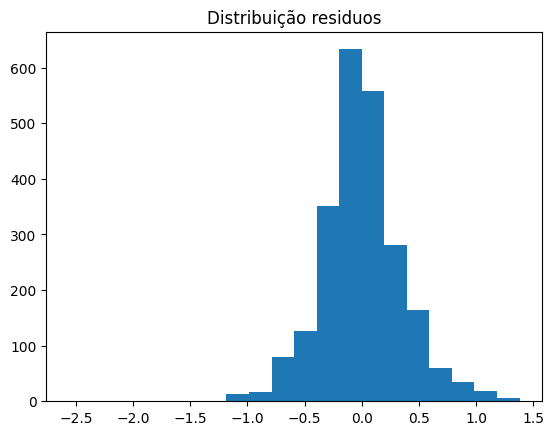

In [17]:
# premissa 7 (extra ~ opcional): RESIDUOS SEGUEM DISTRIBUIÇÃO NORMAL -- almost OK

fig, ax = plt.subplots(1, 1)

ax.hist(res.resid, bins=20)
ax.set_title('Distribuição residuos')

plt.show()

### **Predictive Model**

In [18]:
# PIPELINE (parte2)
df_rl = df.copy()
df_rl = df_rl.drop(['Country'], axis=1)               # muitos valores unicos, tal coluna foi usada para gerar colunas com poucos valores unicos (region, subregion).
df_rl = df_rl.rename(columns={'Status':'Developed'})  # 2 valores unicos em status, tal coluna sera convertida para coluna binaria pois os dois valoes unicos são opostos entre si.
df_rl.columns = [col.replace(' ', '_').replace('/','_').replace('-','_') for col in df_rl.columns]

df_rl = df_rl.drop([                                  # colunas causando multicolinearidade
    'region', 'thinness_5_9_years', 'infant_deaths'
    ], axis=1)                      

print('dummies')
dummies = []
# classic categ dummies
dummies_cols = ['subregion'] # 'region'
dummies += dummies_cols
default_dimmies_cols = []
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for i, val in enumerate(df_rl[col].unique()):
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}_"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
        if i == 0: default_dimmies_cols.append(col_name)
    df_rl = df_rl.drop(col, axis=1)
df_rl = df_rl.drop(default_dimmies_cols, axis=1) # deletando colunas redundantes
# yes or no dummies
dummies_cols = ['Developed']
dummies += dummies_cols
for col in dummies_cols:
    df_rl[col] = (df_rl[col]=='Developed').astype(int)

## dataframe para numpy array
df_rl_fullset = df_rl.copy()

target = 'Life_expectancy'
features = df_rl_fullset.drop(target, axis=1).columns

# train: treinamento do modelo
# cross-valid: escolha de hyperparametros e modelo
# test: insight do score/erro
X, y = df_rl_fullset[features].values, df_rl_fullset[target].values
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=.30, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_cv, y_cv, test_size=1/6, random_state=42)

print()
print('- train')
print(f'features shape: {X_train.shape} ({X_train.shape[0]/X.shape[0]}), target shape: {y_train.shape}')
print('- cross-valid')
print(f'features shape: {X_cv.shape} ({X_cv.shape[0]/X.shape[0]}), target shape: {y_cv.shape}')
print('- test')
print(f'features shape: {X_test.shape} ({X_test.shape[0]/X.shape[0]}), target shape: {y_test.shape}')

print()
print('random train example:')
display(X_train[0, :], y_train[0])

dummies
default for subregion: Southern Asia

- train
features shape: (2049, 40) (0.6997950819672131), target shape: (2049,)
- cross-valid
features shape: (732, 40) (0.25), target shape: (732,)
- test
features shape: (147, 40) (0.050204918032786885), target shape: (147,)

random train example:


array([2.00100000e+03, 1.00000000e+00, 4.51000000e+06, 9.17000000e-01,
       1.75000000e+01, 5.49000000e+00, 3.85495893e+04, 5.40000000e+01,
       8.00000000e-01, 8.65000000e+00, 9.10000000e+01, 9.10000000e+01,
       9.10000000e+01, 8.20000000e+01, 0.00000000e+00, 1.00000000e-01,
       4.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

np.float64(78.8)

In [19]:
# transformador completo (é parte do PIPELINE, porem não esta na celula anterior por sera testado transformações diferentes)
def transform_train_set(X_train, exp):
    '''
        1. recebe os dados de entrada de treino (features)
        2. aplica transformações (feature engineering polinomios e padronização z-score)
        3. retorna os dados de entrada transformados e os transformadores (para transformarem os dados de entrada de teste ~> simulando um cenario de deploy, onde os transformadores são guardados como arquivo) 
    '''

    # feature engineering
    poly = PolynomialFeatures(exp, interaction_only=False, include_bias=False) # poly.get_feature_names_out()) "dicionario" das interações.
    poly.fit(X_train)
    X_train = poly.transform(X_train)

    # padronização
    scaler = StandardScaler() # padronização
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    return X_train, poly, scaler

#### *Modelo 1:* regressão linear

grau melhor ajustado sob dados de validação: 2.
R2 ~> train: 0.9734228891055636, cv: 0.9295631333395887
RMSE ~> train: 1.5628909627994463, cv: 2.4708400595438778
MAPE ~> train: 0.016213549366745485, cv: 0.02377177547411485


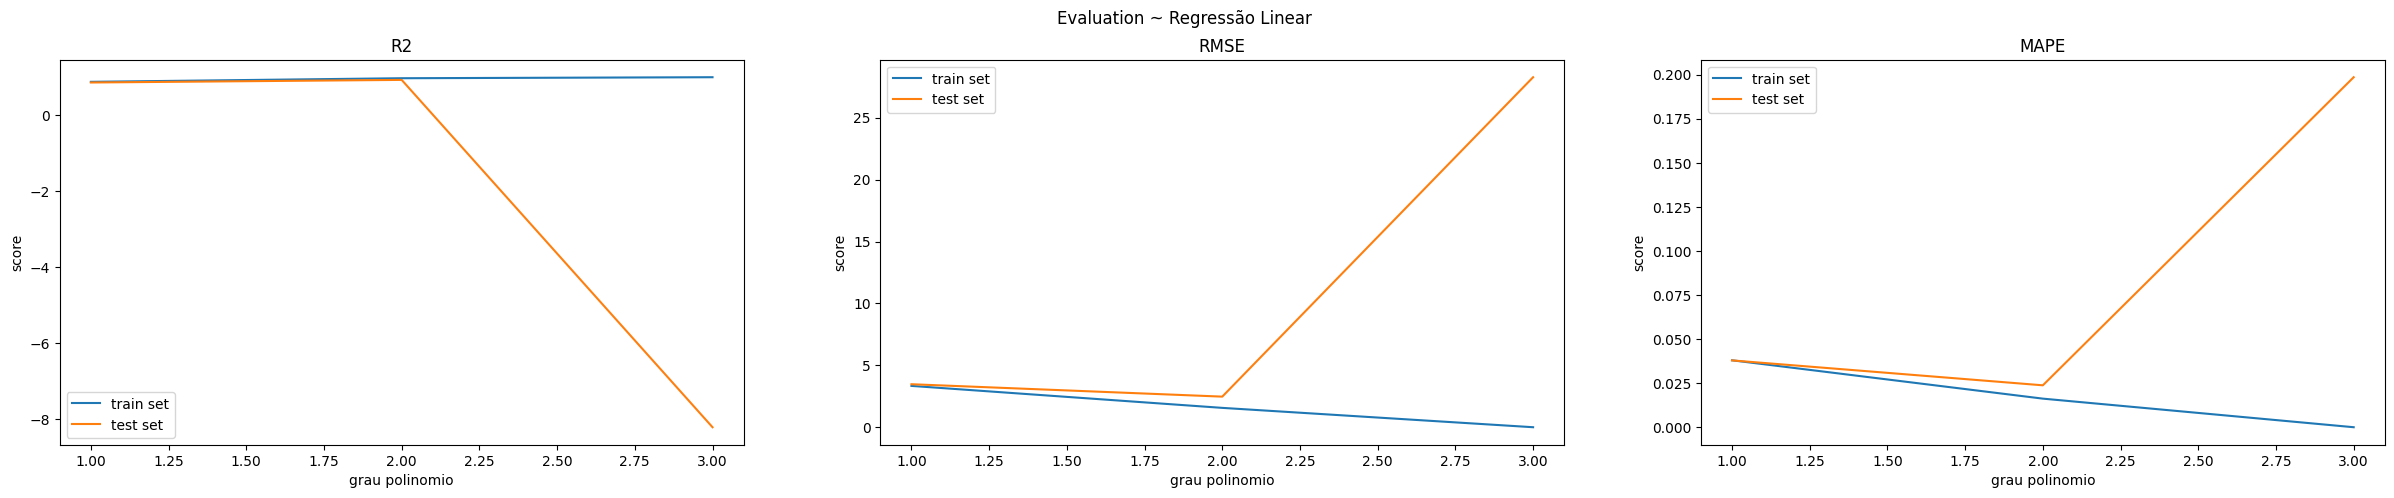

In [20]:
labels = ['train set', 'test set']
scores = {
    'RMSE': [],
    'MAPE': [],
    'R2': []
}
exps = list(range(1, 4))
best_cv_r2_score_reglin = -np.inf
best_exp = None

for i in exps:
    X_train_i, poly, scaler = transform_train_set(X_train, i)
    
    X_cv_i = poly.transform(X_cv)
    X_cv_i = scaler.transform(X_cv_i)

    model_i = LinearRegression()
    model_i.fit(X_train_i, y_train)

    # train val
    y_pred = model_i.predict(X_train_i)
    y_true = y_train

    train_rmse = mean_squared_error(y_true, y_pred)**.5
    train_mape = mean_absolute_percentage_error(y_true, y_pred)
    train_r2 = r2_score(y_true, y_pred)

    # cv val
    y_pred = model_i.predict(X_cv_i)
    y_true = y_cv

    cv_rmse = mean_squared_error(y_true, y_pred)**.5
    cv_mape = mean_absolute_percentage_error(y_true, y_pred)
    cv_r2 = r2_score(y_true, y_pred)

    scores['RMSE'].append([train_rmse, cv_rmse])
    scores['MAPE'].append([train_mape, cv_mape])
    scores['R2'].append([train_r2, cv_r2])

    if cv_r2 > best_cv_r2_score_reglin:
        best_cv_r2_score_reglin = cv_r2
        best_exp = i

fig, axs = plt.subplots(1, 3, figsize=(30, 5))

axs[0].set_title('R2')
axs[0].set_xlabel('grau polinomio')
axs[0].set_ylabel('score')
axs[0].plot(exps, scores['R2'], label=labels)
axs[0].legend()

axs[1].set_title('RMSE')
axs[1].set_xlabel('grau polinomio')
axs[1].set_ylabel('score')
axs[1].plot(exps, scores['RMSE'], label=labels)
axs[1].legend()

axs[2].set_title('MAPE')
axs[2].set_xlabel('grau polinomio')
axs[2].set_ylabel('score')
axs[2].plot(exps, scores['MAPE'], label=labels)
axs[2].legend()

print(f'grau melhor ajustado sob dados de validação: {best_exp}.')
print(f"R2 ~> train: {scores['R2'][best_exp-1][0]}, cv: {scores['R2'][best_exp-1][1]}")
print(f"RMSE ~> train: {scores['RMSE'][best_exp-1][0]}, cv: {scores['RMSE'][best_exp-1][1]}")
print(f"MAPE ~> train: {scores['MAPE'][best_exp-1][0]}, cv: {scores['MAPE'][best_exp-1][1]}")

plt.suptitle('Evaluation ~ Regressão Linear')
plt.show()

#### *Modelo 2:* arvore de decisão regressora

grau melhor ajustado sob dados de validação: 1.
R2 ~> train: 1.0, cv: 0.9211199248789784
RMSE ~> train: 2.7188162185374443e-16, cv: 2.614738595633848
MAPE ~> train: 2.1764144641230244e-19, cv: 0.023072902905998546


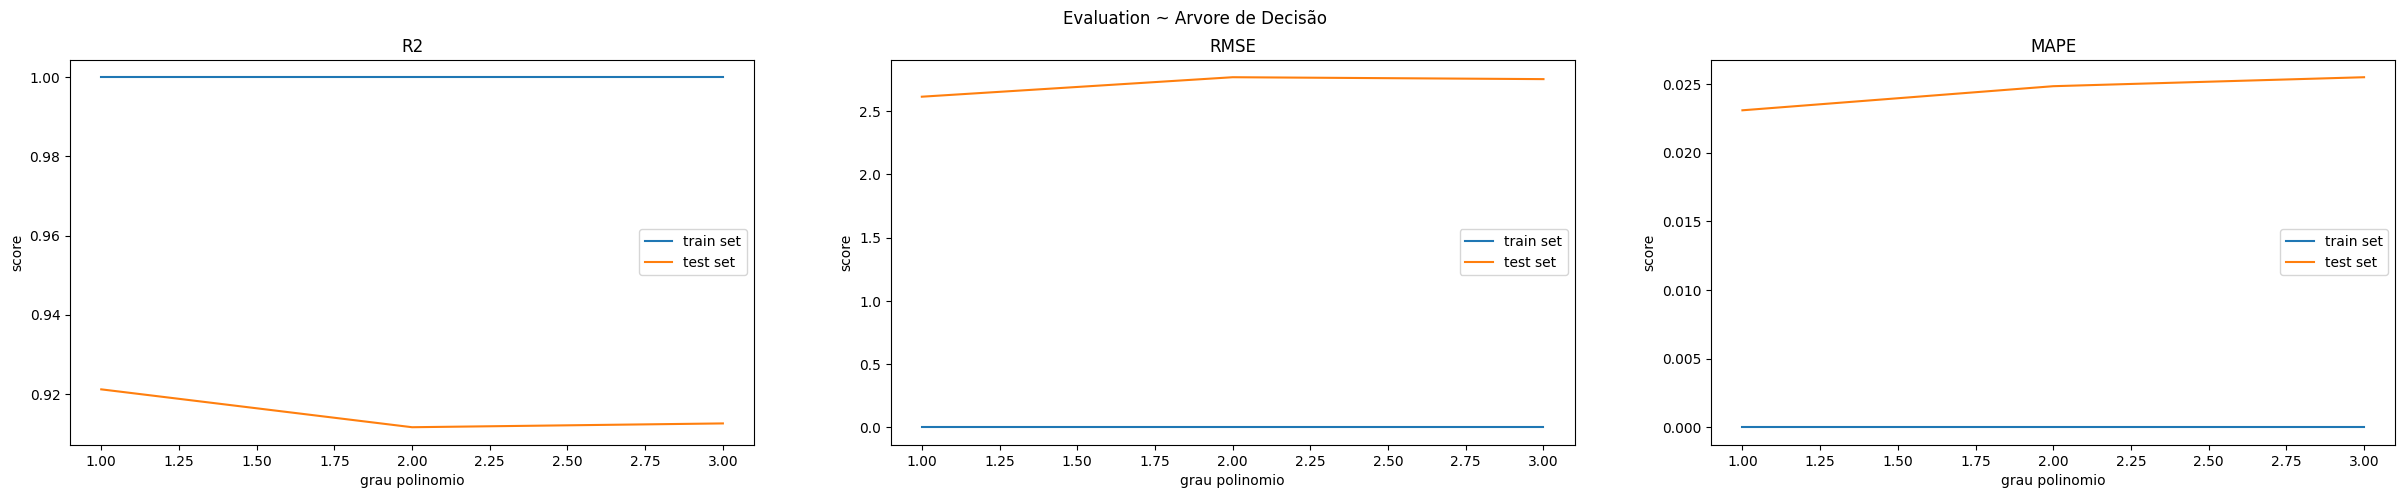

In [21]:
labels = ['train set', 'test set']
scores = {
    'RMSE': [],
    'MAPE': [],
    'R2': []
}
exps = list(range(1, 4))
best_cv_r2_score_dectre = -np.inf
best_exp = None

for i in exps:
    X_train_i, poly, scaler = transform_train_set(X_train, i)
    
    X_cv_i = poly.transform(X_cv)
    X_cv_i = scaler.transform(X_cv_i)

    model_i = DecisionTreeRegressor()
    model_i.fit(X_train_i, y_train)

    # train val
    y_pred = model_i.predict(X_train_i)
    y_true = y_train

    train_rmse = mean_squared_error(y_true, y_pred)**.5
    train_mape = mean_absolute_percentage_error(y_true, y_pred)
    train_r2 = r2_score(y_true, y_pred)

    # cv val
    y_pred = model_i.predict(X_cv_i)
    y_true = y_cv

    cv_rmse = mean_squared_error(y_true, y_pred)**.5
    cv_mape = mean_absolute_percentage_error(y_true, y_pred)
    cv_r2 = r2_score(y_true, y_pred)

    scores['RMSE'].append([train_rmse, cv_rmse])
    scores['MAPE'].append([train_mape, cv_mape])
    scores['R2'].append([train_r2, cv_r2])

    if cv_r2 > best_cv_r2_score_dectre:
        best_cv_r2_score_dectre = cv_r2
        best_exp = i

fig, axs = plt.subplots(1, 3, figsize=(30, 5))

axs[0].set_title('R2')
axs[0].set_xlabel('grau polinomio')
axs[0].set_ylabel('score')
axs[0].plot(exps, scores['R2'], label=labels)
axs[0].legend()

axs[1].set_title('RMSE')
axs[1].set_xlabel('grau polinomio')
axs[1].set_ylabel('score')
axs[1].plot(exps, scores['RMSE'], label=labels)
axs[1].legend()

axs[2].set_title('MAPE')
axs[2].set_xlabel('grau polinomio')
axs[2].set_ylabel('score')
axs[2].plot(exps, scores['MAPE'], label=labels)
axs[2].legend()

print(f'grau melhor ajustado sob dados de validação: {best_exp}.')
print(f"R2 ~> train: {scores['R2'][best_exp-1][0]}, cv: {scores['R2'][best_exp-1][1]}")
print(f"RMSE ~> train: {scores['RMSE'][best_exp-1][0]}, cv: {scores['RMSE'][best_exp-1][1]}")
print(f"MAPE ~> train: {scores['MAPE'][best_exp-1][0]}, cv: {scores['MAPE'][best_exp-1][1]}")

plt.suptitle('Evaluation ~ Arvore de Decisão')
plt.show()

#### *Modelo 3:*  floresta aleatória regressora

grau melhor ajustado sob dados de validação: 1.
R2 ~> train: 0.9949906767561216, cv: 0.9563369161896543
RMSE ~> train: 0.6785226102718126, cv: 1.94536824516327
MAPE ~> train: 0.006268766277840084, cv: 0.017426115012597557


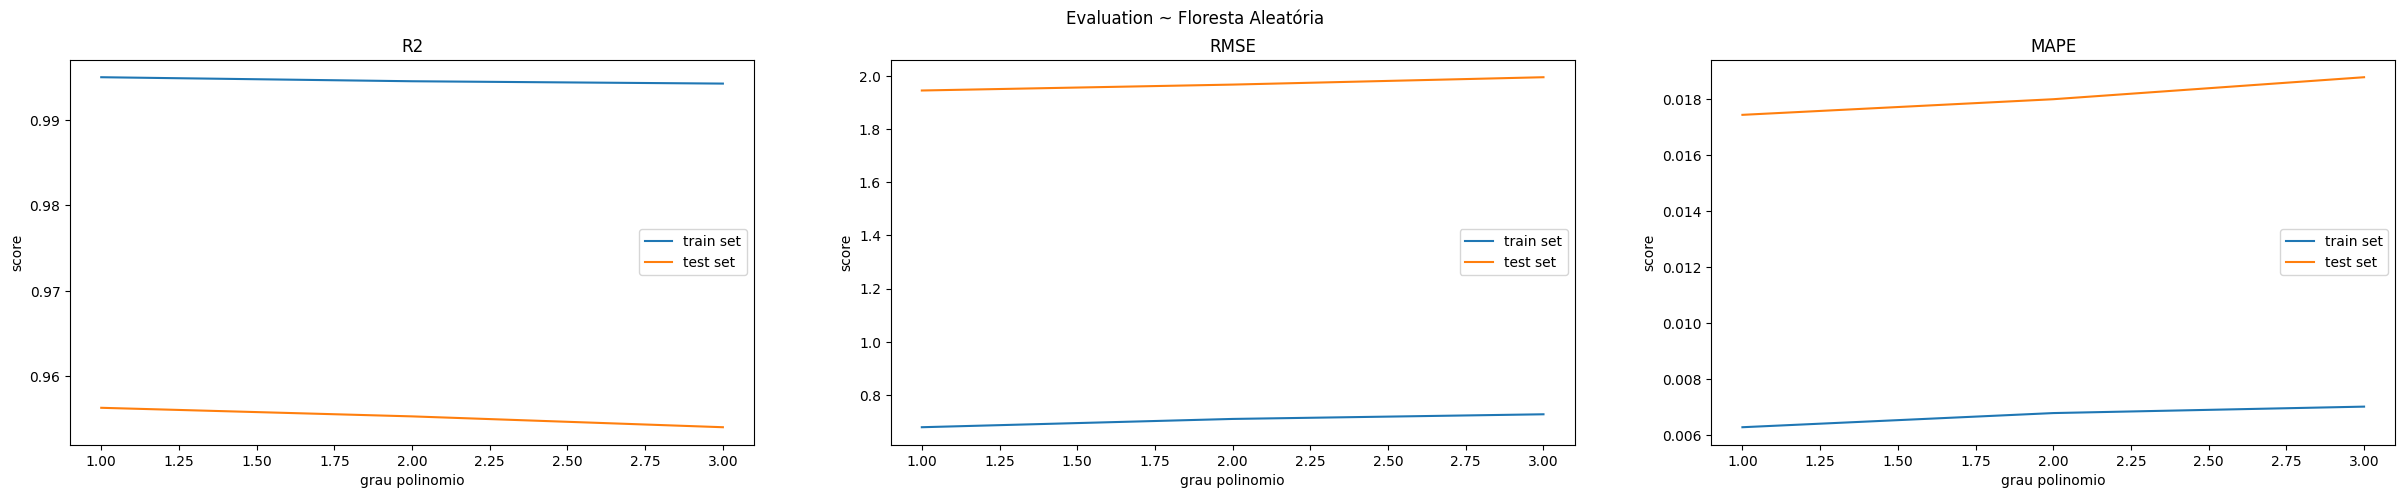

In [22]:
labels = ['train set', 'test set']
scores = {
    'RMSE': [],
    'MAPE': [],
    'R2': []
}
exps = list(range(1, 4))
best_cv_r2_score_randfore = -np.inf
best_exp = None

for i in exps:
    X_train_i, poly, scaler = transform_train_set(X_train, i)
    
    X_cv_i = poly.transform(X_cv)
    X_cv_i = scaler.transform(X_cv_i)

    model_i = RandomForestRegressor()
    model_i.fit(X_train_i, y_train)

    # train val
    y_pred = model_i.predict(X_train_i)
    y_true = y_train

    train_rmse = mean_squared_error(y_true, y_pred)**.5
    train_mape = mean_absolute_percentage_error(y_true, y_pred)
    train_r2 = r2_score(y_true, y_pred)

    # cv val
    y_pred = model_i.predict(X_cv_i)
    y_true = y_cv

    cv_rmse = mean_squared_error(y_true, y_pred)**.5
    cv_mape = mean_absolute_percentage_error(y_true, y_pred)
    cv_r2 = r2_score(y_true, y_pred)

    scores['RMSE'].append([train_rmse, cv_rmse])
    scores['MAPE'].append([train_mape, cv_mape])
    scores['R2'].append([train_r2, cv_r2])

    if cv_r2 > best_cv_r2_score_randfore:
        best_cv_r2_score_randfore = cv_r2
        best_exp = i

fig, axs = plt.subplots(1, 3, figsize=(30, 5))

axs[0].set_title('R2')
axs[0].set_xlabel('grau polinomio')
axs[0].set_ylabel('score')
axs[0].plot(exps, scores['R2'], label=labels)
axs[0].legend()

axs[1].set_title('RMSE')
axs[1].set_xlabel('grau polinomio')
axs[1].set_ylabel('score')
axs[1].plot(exps, scores['RMSE'], label=labels)
axs[1].legend()

axs[2].set_title('MAPE')
axs[2].set_xlabel('grau polinomio')
axs[2].set_ylabel('score')
axs[2].plot(exps, scores['MAPE'], label=labels)
axs[2].legend()

print(f'grau melhor ajustado sob dados de validação: {best_exp}.')
print(f"R2 ~> train: {scores['R2'][best_exp-1][0]}, cv: {scores['R2'][best_exp-1][1]}")
print(f"RMSE ~> train: {scores['RMSE'][best_exp-1][0]}, cv: {scores['RMSE'][best_exp-1][1]}")
print(f"MAPE ~> train: {scores['MAPE'][best_exp-1][0]}, cv: {scores['MAPE'][best_exp-1][1]}")

plt.suptitle('Evaluation ~ Floresta Aleatória')
plt.show()

#### **Melhor** modelo

In [23]:

print(f'''R2 ~ regressão linear: {best_cv_r2_score_reglin}
R2 ~ arvore de decisão: {best_cv_r2_score_dectre}
R2 ~ floresta aleatória: {best_cv_r2_score_randfore}''')

R2 ~ regressão linear: 0.9295631333395887
R2 ~ arvore de decisão: 0.9211199248789784
R2 ~ floresta aleatória: 0.9563369161896543


O melhor modelo foi o de **Floresta Aleatória** sem a necessidade de feature engineering (pois arvores de decisão capturam bem associações). <br>
R² de **0.9550** sobre o set de validação e **0.9949** sobre o set de treinamento. <br>
RMSE de **1.9733** sobre o set de validação e **0.6843** sobre o set de treinamento. <br>
MAPE de **0.0176** sobre o set de validação e **0.0064** sobre o set de treinamento. <br>

R2 ~> train: 0.994955369831987, test: 0.9686065114435608
RMSE ~> train: 0.6809096075152994, test: 1.7025054686397638
MAPE ~> train: 0.006333645350687843, test: 0.016510341782644055


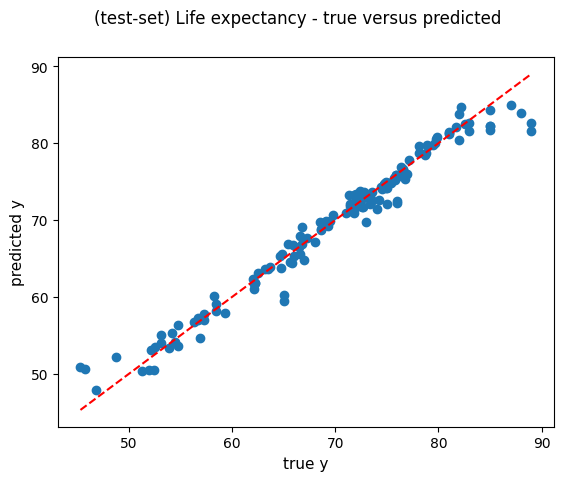

In [24]:
X_train_final, poly, scaler = transform_train_set(X_train, 1)
    
X_test_final = poly.transform(X_test)
X_test_final = scaler.transform(X_test_final)

model_final = RandomForestRegressor()
model_i.fit(X_train_final, y_train)

# train val
y_pred = model_i.predict(X_train_final)
y_true = y_train

train_rmse = mean_squared_error(y_true, y_pred)**.5
train_mape = mean_absolute_percentage_error(y_true, y_pred)
train_r2 = r2_score(y_true, y_pred)

# test val
y_pred = model_i.predict(X_test_final)
y_true = y_test

test_rmse = mean_squared_error(y_true, y_pred)**.5
test_mape = mean_absolute_percentage_error(y_true, y_pred)
test_r2 = r2_score(y_true, y_pred)

print(f"R2 ~> train: {train_r2}, test: {test_r2}")
print(f"RMSE ~> train: {train_rmse}, test: {test_rmse}")
print(f"MAPE ~> train: {train_mape}, test: {test_mape}")

plt.scatter(x=y_true, y=y_pred)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')

plt.xlabel('true y', fontsize=11)
plt.ylabel('predicted y', fontsize=11)
plt.suptitle('(test-set) Life expectancy - true versus predicted')

plt.show()